<a href="https://colab.research.google.com/github/leyli16/HousingPricePrediction/blob/main/545_Group36_Final_project_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 1. Background**

## Group 36 Project: Part 2 — Macro-Level Analysis

This notebook represents **Part 2** of our overall housing price modeling project. While **Part 1** focuses on a **micro-level perspective** — analyzing individual property transactions and leveraging features such as local demographics, economic indicators, and spatial attributes — this portion emphasizes a **macro-level, longitudinal approach**.

Specifically, our analysis explores how **demographic composition**, **FEMA disaster history**, and **geographic attributes** interact with the **Housing Price Index (HPI)** over a 30-year timespan (1990–2020), primarily at the **ZIP code level**.

This macro lens allows us to uncover broad national and regional trends, detect long-term correlations between social or environmental factors and housing prices, and offer high-level insights that complement the granular, transaction-based modeling in Part 1.

Together, these two parts form a comprehensive, multi-scale understanding of the U.S. housing market.




Import Library


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import datetime as dt
import requests
from lxml import html
import math
import json
import re
import os

#**Chapter 2. DATA WRANGLING**

This chapter focuses on transforming raw datasets into analysis-ready tables through a structured cleaning and integration process. We processed four key data sources:

1. **Part 1: Geographic Reference Mapping**  
   - Cleaned and standardized ZIP-to-FIPS and ZIP-to-MSA datasets.  
   - Merged them into a unified mapping table to link ZIP codes with counties and metropolitan areas.  
   - **Intermediate Output**: `merged_zip_fips_MSA_df` (39,423 rows × 8 columns)

2. **Part 2: County Demographics**  
   - Cleaned and deduplicated demographic data by FIPS and year.  
   - Merged it with the geographic mapping to assign ZIP codes and MSA info.  
   - **Final Output**: `county_demographics_merged_df` (1,623,972 rows × 23 columns)

3. **Part 3: FEMA Disaster Declarations**  
   - Filtered FEMA records (1990–2020), constructed full FIPS codes, and merged with ZIP-level mappings.  
   - Resulted in expanded disaster entries at the ZIP level.  
   - **Final Output**: `fema_with_zip_MSA_df` (712,529 rows × 16 columns)

4. **Part 4: HPI Housing Price Index**  
   - Cleaned HPI time series data by ZIP, dropped sparsely populated columns, and handled missing values.  
   - Transformed data into wide format for time series analysis and merged with ZIP-geographic metadata.  
   - **Final Output**: `clean_hpi_geo_df` (27,620 rows × 71 columns)


## Part 1: Geo Mapping (Zip, FIPS, County, MSA, State)


In this section, we processed two key datasets used for geographic mapping:

**2.1.1** **ZIP-COUNTY-FIPS Crosswalk Dataset**  
   Sourced from Kaggle, this dataset provides a mapping between ZIP codes and county-level FIPS codes, along with related geographic identifiers such as state and county names. We cleaned the data by standardizing ZIP and FIPS formats, renaming columns, removing irrelevant features, and deduplicating ZIP-level entries.

**2.2.1** **ZIP to MSA (Metropolitan Statistical Area) Mapping**  
   Sourced from Kaggle as well, this dataset contains ZIP-to-MSA relationships. We cleaned this dataset by renaming fields, removing unnecessary geographic economic indicators (e.g., GPCI), and ensuring consistent ZIP formatting.

**Final Output: `merged_zip_fips_MSA_df`**  
By merging the above datasets on the standardized `zip_code` field, we produced a unified geographic reference table named `merged_zip_fips_MSA_df` with **39,423 rows and 8 columns**. This table enables consistent ZIP-level referencing and will serve as a foundational dataset for merging with FEMA disaster records and demographic datasets in later stages.



### 2.1.1 Zip FIPS Mapping


We started by downloading the ZIP to County FIPS crosswalk dataset from Kaggle.

`1. ZIP-COUNTY-FIPS Crosswalk Dataset`: `ZIP-COUNTY-FIPS_2017-06.csv`.

This dataset maps ZIP codes to county-level FIPS codes along with associated county and state names.


In [129]:
%%capture
!pip instsall kaggle

# !mkdir ~/.kaggle
# !cp \\nasprodpm\home\jyan\kaggle.json ~/.kaggle/

# !!kaggle datasets download danofer/zipcodes-county-fips-crosswalk

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [132]:
!!kaggle datasets download danofer/zipcodes-county-fips-crosswalk


['Dataset URL: https://www.kaggle.com/datasets/danofer/zipcodes-county-fips-crosswalk',
 'License(s): CC0-1.0',
 'zipcodes-county-fips-crosswalk.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [133]:
!unzip zipcodes-county-fips-crosswalk.zip

Archive:  zipcodes-county-fips-crosswalk.zip
replace ZIP-COUNTY-FIPS_2017-06.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ZIP-COUNTY-FIPS_2017-06.csv  


We then read the file `ZIP-COUNTY-FIPS_2017-06.csv` into a pandas DataFrame named `zip_fips_df`. Below is the structure of the dataset:

- **52889 rows × 5 columns**
- Key columns include:
  - `ZIP`: ZIP code (integer)
  - `COUNTYNAME`: Full county name (string)
  - `STATE`: 2-letter state abbreviation
  - `STCOUNTYFP`: 5-digit county-level FIPS code
  - `CLASSFP`: Classification code for geographic features (not needed for our analysis)

This raw dataset forms the basis for linking ZIP-level geographic records to FIPS codes used in other datasets.

In [134]:
zip_fips_df = pd.read_csv('ZIP-COUNTY-FIPS_2017-06.csv')
zip_fips_df.info()
zip_fips_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52889 entries, 0 to 52888
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ZIP         52889 non-null  int64 
 1   COUNTYNAME  52889 non-null  object
 2   STATE       52889 non-null  object
 3   STCOUNTYFP  52889 non-null  int64 
 4   CLASSFP     52889 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


,ZIP,COUNTYNAME,STATE,STCOUNTYFP,CLASSFP
0,36003,Autauga County,AL,1001,H1
1,36006,Autauga County,AL,1001,H1
2,36067,Autauga County,AL,1001,H1
3,36066,Autauga County,AL,1001,H1
4,36703,Autauga County,AL,1001,H1


After loading the raw ZIP-to-FIPS mapping data from Kaggle (`ZIP-COUNTY-FIPS_2017-06.csv`) and named as `zip_fips_df`, we performed a series of preprocessing steps to clean and standardize the dataset for later merging:

**Step 1: Inspect uniqueness**
  We confirmed that there are 3,223 unique FIPS codes in the dataset

In [135]:
unique_fips = zip_fips_df['STCOUNTYFP'].nunique()
print(f"Unique FIPS codes: {unique_fips}")

# Drop NaNs and get unique FIPS codes as a list
unique_fips_list = zip_fips_df['STCOUNTYFP'].dropna().unique().tolist()

# Display the list
# print(unique_fips_list)

Unique FIPS codes: 3223


**Step 2: Convert FIPS to string**  To ensure compatibility across datasets, we created a new column fips_string by converting numeric FIPS codes (STCOUNTYFP) to 5-digit strings:

In [ ]:
# Convert FIPS to 5-digit string
zip_fips_df['fips_string'] = zip_fips_df['STCOUNTYFP'].astype(str).str.zfill(5)

**Step 3: Check ZIP and FIPS coverage**  We verified there are 39,456 unique ZIP codes and 3,223 unique FIPS codes (again) after cleaning:

In [ ]:
unique_fips_list_5 = zip_fips_df['fips_string'].dropna().unique().tolist()
print(unique_fips_list_5)

['01001', '01003', '01005', '01007', '01009', '01011', '01013', '01015', '01017', '01019', '01021', '01023', '01025', '01027', '01029', '01031', '01033', '01035', '01037', '01039', '01041', '01043', '01045', '01047', '01049', '01051', '01053', '01055', '01057', '01059', '01061', '01063', '01065', '01067', '01069', '01071', '01073', '01075', '01077', '01079', '01081', '01083', '01085', '01087', '01089', '01091', '01093', '01095', '01097', '01099', '01101', '01103', '01105', '01107', '01109', '01111', '01113', '01115', '01117', '01119', '01121', '01123', '01125', '01127', '01129', '01131', '01133', '02013', '02016', '02020', '02050', '02060', '02068', '02070', '02090', '02100', '02105', '02110', '02122', '02130', '02150', '02164', '02170', '02180', '02185', '02188', '02195', '02198', '02220', '02230', '02240', '02261', '02270', '02275', '02282', '02290', '04001', '04003', '04005', '04007', '04009', '04011', '04012', '04013', '04015', '04017', '04019', '04021', '04023', '04025', '04027', 

In [ ]:
# Unique ZIPs (based on ZIP_STRING or ZIP)
unique_zips = zip_fips_df['ZIP'].nunique()

# Unique FIPS (excluding NaNs)
unique_fips = zip_fips_df['fips_string'].nunique()

print(f"Unique ZIP codes: {unique_zips}")
print(f"Unique FIPS codes: {unique_fips}")

Unique ZIP codes: 39456
Unique FIPS codes: 3223


**Step 4: Standardize ZIP format and rename column**  ZIP codes were converted to 5-digit strings:

  *   Renamed COUNTYNAME to county_name
  *   Dropped CLASSFP (not needed)
  *   Converted all column names to lowercase




In [ ]:
# Clean Zip as 5-digit string
zip_fips_df["ZIP"] = zip_fips_df["ZIP"].apply(lambda x: f"{int(x):05}")

# Rename columns
zip_fips_df = zip_fips_df.rename(columns={"COUNTYNAME": "county_name"})

# Drop useless columns
zip_fips_df = zip_fips_df.drop(columns=['CLASSFP'])

# Convert column names to lower case
zip_fips_df.columns = zip_fips_df.columns.str.lower()

zip_fips_df.info()
zip_fips_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52889 entries, 0 to 52888
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   zip          52889 non-null  object
 1   county_name  52889 non-null  object
 2   state        52889 non-null  object
 3   stcountyfp   52889 non-null  int64 
 4   fips_string  52889 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


,zip,county_name,state,stcountyfp,fips_string
0,36003,Autauga County,AL,1001,01001
1,36006,Autauga County,AL,1001,01001
2,36067,Autauga County,AL,1001,01001
3,36066,Autauga County,AL,1001,01001
4,36703,Autauga County,AL,1001,01001


**Step 5: Deduplicate to one ZIP-FIPS mapping per ZIP**: To ensure one-to-one mapping between each ZIP and FIPS code, we sorted the dataframe and removed duplicates based on ZIP:


In [ ]:
# Deduplicate zip_fips mapping
zip_fips_df_dedup = zip_fips_df.sort_values(by=["zip", "fips_string"]).drop_duplicates(subset=["zip"], keep="first")
zip_fips_df_dedup["zip_code"] = zip_fips_df_dedup["zip"].apply(lambda x: f"{int(x):05}")
zip_fips_df_dedup = zip_fips_df_dedup.drop(columns=["zip"])  # drop redundant


In [ ]:
zip_fips_df_dedup.info()
zip_fips_df_dedup.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 39456 entries, 32368 to 1333
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   county_name  39456 non-null  object
 1   state        39456 non-null  object
 2   stcountyfp   39456 non-null  int64 
 3   fips_string  39456 non-null  object
 4   zip_code     39456 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


,county_name,state,stcountyfp,fips_string,zip_code
32368,Suffolk County,NY,36103,36103,00501
52575,Adjuntas Municipio,PR,72001,72001,00601
52576,Aguada Municipio,PR,72003,72003,00602
52579,Aguadilla Municipio,PR,72005,72005,00603
52580,Aguadilla Municipio,PR,72005,72005,00604




---


**Intermediate Output**: `zip_fips_df_dedup`.

The cleaned and deduplicated DataFrame zip_fips_df_dedup contains 39,456 unique ZIP codes and includes the following fields:


*   `county_name`: Name of the county

*   `state`: State abbreviation

*   `stcountyfp`: Numeric FIPS code

*   `fips_string`: Standardized 5-digit FIPS string

*   `zip_code`: 5-digit ZIP code string


This dataset now provides a one-to-one ZIP-to-FIPS mapping, ready for merging with other geographically-referenced datasets.


---



### 2.1.2 Zip MSA Mapping

In this section, we processed a dataset containing the mapping between ZIP codes and Metropolitan Statistical Areas (MSAs). The data was sourced from Kaggle (`haakakak/msabyzip`) and provided in the Excel file `fs11_gpci_by_msa-ZIP.xls`.


In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/fs11_gpci_by_msa-ZIP.xls'

# Define the file path

# file_path = '/home/jyan/fs11_gpci_by_msa-ZIP.xls' # Use a raw string


# Read the Excel file
zip_MSA_df = pd.read_excel(file_path)
zip_MSA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43508 entries, 0 to 43507
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZIP CODE    43508 non-null  int64  
 1   STATE       43508 non-null  object 
 2   MSA No.     43497 non-null  float64
 3   GPCI        43497 non-null  float64
 4   GPCI.1      43497 non-null  float64
 5   GPCI.2      43497 non-null  float64
 6   County No.  43496 non-null  float64
 7   Unnamed: 7  43508 non-null  int64  
 8   MSA Name    43497 non-null  object 
 9   Unnamed: 9  6 non-null      object 
dtypes: float64(5), int64(2), object(3)
memory usage: 3.3+ MB


- **Step 1: Standardize ZIP codes**  
  Converted `ZIP CODE` to 5-digit string format and renamed to `zip_code`.

- **Step 2: Rename columns for clarity**  
  - `Unnamed: 7` ➝ `zip_no`  
  - `MSA Name` ➝ `msa_name`  
  - `County No.` ➝ `county_no`, with missing values filled as 0 and converted to integer type.

- **Step 3: Drop irrelevant columns**  
  Removed unused columns that are not needed for mapping:
  `"MSA No.", "GPCI", "GPCI.1", "GPCI.2", "County No.", "Unnamed: 9", "STATE"`

- **Step 4: Normalize column names**  
  Converted all column names to lowercase for consistency across datasets.

In [ ]:
# Clean Zip as 5-digit string
zip_MSA_df["ZIP CODE"] = zip_MSA_df["ZIP CODE"].apply(lambda x: f"{int(x):05}")
zip_MSA_df = zip_MSA_df.rename(columns={"ZIP CODE": "ZIP_code"})

# Rename Columns: Unnamed:7 into zip_no as int64
zip_MSA_df = zip_MSA_df.rename(columns={"Unnamed: 7": "zip_no"})
zip_MSA_df = zip_MSA_df.rename(columns={"MSA Name": "msa_name"})

# Convert county No. as int64 and rename field
zip_MSA_df["county_no"] = zip_MSA_df["County No."].fillna(0).astype("int64")

# Drop meaningless or repetitive columns
columns_to_drop = ["MSA No.", "GPCI", "GPCI.1", "GPCI.2", "County No.", "Unnamed: 9", "STATE"]
zip_MSA_df = zip_MSA_df.drop(columns=columns_to_drop)

# Convert column names to lower case
zip_MSA_df.columns = zip_MSA_df.columns.str.lower()

In [ ]:
zip_MSA_df.head(5)

,zip_code,zip_no,msa_name,county_no
0,00210,210,"Boston-Cambridge-Quincy, MA-NH MSA",15
1,00211,211,"Boston-Cambridge-Quincy, MA-NH MSA",15
2,00212,212,"Boston-Cambridge-Quincy, MA-NH MSA",15
3,00213,213,"Boston-Cambridge-Quincy, MA-NH MSA",15
4,00214,214,"Boston-Cambridge-Quincy, MA-NH MSA",15




---


**Intermediate Output**: `zip_MSA_df`.

The cleaned DataFrame `zip_MSA_df` contains 43,508 ZIP-level entries with ZIP-to-MSA mappings and includes the following fields:

* `zip_code`: 5-digit ZIP code (string)
* `zip_no`: ZIP order number (integer)
* `msa_name`: Name of the Metropolitan Statistical Area (string)
* `county_no`: County number (integer)

This dataset now provides a standardized ZIP-to-MSA mapping and is ready to be merged with the ZIP-FIPS mapping table to form a unified geographic reference for downstream analysis.



---




### 2.1.3 Merge & Check Effectivenss of Merge

In this step, we merged the two cleaned datasets `zip_MSA_df` and `zip_fips_df` to create a unified geographic reference table that includes ZIP code, county, state, and MSA information.


In [ ]:
# Check the number of rows before merge
print("Rows in zip_MSA_df before merge:", len(zip_MSA_df))
print("Rows in zip_fips_df_dedup before merge:", len(zip_fips_df_dedup))

Rows in zip_MSA_df before merge: 43508
Rows in zip_fips_df_dedup before merge: 39456


In [ ]:
merged_zip_fips_MSA_df = pd.merge(zip_MSA_df, zip_fips_df_dedup, left_on='zip_code', right_on='zip_code', how='inner')

In [ ]:
# ZIPs in zip_MSA_df that are not in zip_fips_df_dedup
unmatched_zip_MSA = zip_MSA_df[~zip_MSA_df['zip_code'].isin(zip_fips_df_dedup['zip_code'])]

# ZIPs in zip_fips_df_dedup that are not in zip_MSA_df
unmatched_zip_fips = zip_fips_df_dedup[~zip_fips_df_dedup['zip_code'].isin(zip_MSA_df['zip_code'])]


# Print summary counts
print("Unmatched rows count:")
print("- From zip_MSA_df:", len(unmatched_zip_MSA))
print("- From zip_fips_df_dedup:", len(unmatched_zip_fips))

# Print the first few rows from each
print("\n Sample unmatched rows from zip_MSA_df:")
display(unmatched_zip_MSA.head(10))

print("\n Sample unmatched rows from zip_fips_df_dedup:")
display(unmatched_zip_fips.head(10))


Unmatched rows count:
- From zip_MSA_df: 4085
- From zip_fips_df_dedup: 33

 Sample unmatched rows from zip_MSA_df:


,zip_code,zip_no,msa_name,county_no
0,00210,210,"Boston-Cambridge-Quincy, MA-NH MSA",15
1,00211,211,"Boston-Cambridge-Quincy, MA-NH MSA",15
2,00212,212,"Boston-Cambridge-Quincy, MA-NH MSA",15
3,00213,213,"Boston-Cambridge-Quincy, MA-NH MSA",15
4,00214,214,"Boston-Cambridge-Quincy, MA-NH MSA",15
5,00215,215,"Boston-Cambridge-Quincy, MA-NH MSA",15
7,00544,544,"New York-Northern New Jersey-Long Island, NY-N...",103
26,00636,636,"San German-Cabo Rojo, PR MSA",125
81,00734,734,"Ponce, PR MSA",113
115,00801,801,VI NONMETROPOLITAN AREA,30



 Sample unmatched rows from zip_fips_df_dedup:


,county_name,state,stcountyfp,fips_string,zip_code
48969,Alexandria city,VA,51510,51510,22350
50221,Fayette County,WV,54019,54019,25888
33356,Guilford County,NC,37081,37081,27268
41221,Berkeley County,SC,45015,45015,29486
8013,Miami-Dade County,FL,12086,12086,33191
8011,Miami-Dade County,FL,12086,12086,33198
7930,Miami-Dade County,FL,12086,12086,33206
7746,Lee County,FL,12071,12071,33929
8519,Sarasota County,FL,12115,12115,34249
7332,Citrus County,FL,12017,12017,34441


Why Some ZIP Codes Failed to Match

After performing an inner join between `zip_MSA_df` and `zip_fips_df_dedup`, we observed unmatched ZIP codes from both datasets. Here’s an analysis of why these mismatches occurred:

- **Unmatched ZIPs from `zip_MSA_df` (4,085 entries):**
  These ZIP codes have MSA assignments but are missing from the FIPS dataset. Common reasons include:
  - **PO Boxes or special-use ZIPs:** Examples like `00210–00215` are used for federal agencies or post office boxes, which are not tied to specific counties.
  - **U.S. Territories:** ZIPs from Puerto Rico (`00636`, `00734`) and the Virgin Islands (`00801`) are included in MSA designations but often excluded or handled differently in county-based FIPS datasets.
  - **Retired or non-standard ZIPs:** ZIPs like `00544` may be obsolete or reserved for specific federal agencies (e.g., IRS).

- **Unmatched ZIPs from `zip_fips_df_dedup` (33 entries):**
  These ZIP codes have FIPS mappings but are missing from the MSA dataset. Common reasons include:
  - **Non-metropolitan areas:** Many of these ZIPs correspond to rural or low-population areas not covered by any Metropolitan Statistical Area (e.g., Fayette County, WV).
  - **Independent cities or unique jurisdictions:** Locations like Alexandria, VA are treated as independent entities and may be excluded from MSA assignments.
  - **Recent or infrequently used ZIPs:** Some ZIPs may be newly assigned or infrequently referenced in economic datasets like the one used for MSA mapping.

By using an inner join, we retained only the ZIP codes with consistent and reliable mappings in both FIPS and MSA systems—ensuring the resulting geographic reference table is suitable for downstream analysis.



In [ ]:
merged_zip_fips_MSA_df.info()

print("Rows in merged_zip_fips_MSA_df after merge :", len(merged_zip_fips_MSA_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39423 entries, 0 to 39422
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   zip_code     39423 non-null  object
 1   zip_no       39423 non-null  int64 
 2   msa_name     39423 non-null  object
 3   county_no    39423 non-null  int64 
 4   county_name  39423 non-null  object
 5   state        39423 non-null  object
 6   stcountyfp   39423 non-null  int64 
 7   fips_string  39423 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.4+ MB
Rows in merged_zip_fips_MSA_df after merge : 39423


In [ ]:
merged_zip_fips_MSA_df.head(10)

,zip_code,zip_no,msa_name,county_no,county_name,state,stcountyfp,fips_string
0,00501,501,"New York-Northern New Jersey-Long Island, NY-N...",103,Suffolk County,NY,36103,36103
1,00601,601,PR NONMETROPOLITAN AREA,1,Adjuntas Municipio,PR,72001,72001
2,00602,602,"Aguadilla-Isabela-San Sebastian, PR MSA",3,Aguada Municipio,PR,72003,72003
3,00603,603,"Aguadilla-Isabela-San Sebastian, PR MSA",5,Aguadilla Municipio,PR,72005,72005
4,00604,604,"Aguadilla-Isabela-San Sebastian, PR MSA",5,Aguadilla Municipio,PR,72005,72005
5,00605,605,"Aguadilla-Isabela-San Sebastian, PR MSA",5,Aguadilla Municipio,PR,72005,72005
6,00606,606,PR NONMETROPOLITAN AREA,93,Maricao Municipio,PR,72093,72093
7,00610,610,"Aguadilla-Isabela-San Sebastian, PR MSA",11,Anasco Municipio,PR,72011,72011
8,00611,611,PR NONMETROPOLITAN AREA,141,Utuado Municipio,PR,72141,72141
9,00612,612,"San Juan-Caguas-Guaynabo, PR MSA",13,Arecibo Municipio,PR,72013,72013




---


####**Final Output**: `merged_zip_fips_MSA_df`

The final merged dataset `merged_zip_fips_MSA_df` contains **39,423** rows, each representing a ZIP code with both Metropolitan Statistical Area (MSA) and county-level FIPS mapping. The table includes the following fields:

- `zip_code`: 5-digit ZIP code (string)
- `zip_no`: ZIP order number
- `msa_name`: Name of the associated MSA
- `county_no`: County number (from MSA dataset)
- `county_name`: Full county name
- `state`: State abbreviation
- `stcountyfp`: Numeric FIPS code
- `fips_string`: Standardized 5-digit FIPS code (string)

This dataset serves as a unified ZIP-to-county-to-MSA reference table and provides the geographic foundation for integrating FEMA disaster records and demographic data in the next steps of analysis.


---



## Part 2: County Demographics Data Cleaning and Wrangling



This section prepares county-level demographic data and expands it to the ZIP-code level by merging with the previously constructed geographic mapping dataset.


### 2.2.1 Loading County Demogrphics Dataset
 - Loaded the raw county demographics data, which includes population ratios by race, gender, and age for each county (`fips`) across multiple years.  
 - Verified that the dataset covers all necessary fields and spans multiple time periods for temporal analysis.



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("glozab/county-level-us-demographic-data-1990-2020")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/county-level-us-demographic-data-1990-2020


In [ ]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['county_demographics.csv']


In [ ]:
file_path = os.path.join(path, 'county_demographics.csv')

# file_path = '/home/jyan/county_demographics.csv'
county_demographics_df_raw = pd.read_csv(file_path)

county_demographics_df_raw.head()
# county_demographics_df_raw.describe()


,year,fips,population,w_population,b_population,o_population,nh_population,hi_population,na_population,male_population,...,age9_population_ratio,age10_population_ratio,age11_population_ratio,age12_population_ratio,age13_population_ratio,age14_population_ratio,age15_population_ratio,age16_population_ratio,age17_population_ratio,age18_population_ratio
0,1990,1025,27289,15579,11643,35,27196,93,0,13052,...,0.06263,0.05552,0.04998,0.04482,0.04167,0.03767,0.03324,0.02825,0.01843,0.01319
1,1990,1031,40293,32869,6950,160,39831,462,0,19673,...,0.07455,0.06031,0.05180,0.04894,0.04544,0.04145,0.03430,0.02730,0.01660,0.01258
2,1990,1041,13598,10068,3516,11,13576,22,0,6421,...,0.06582,0.05354,0.04574,0.04765,0.05104,0.05273,0.04633,0.03876,0.02456,0.01839
3,1990,1053,35526,24377,10050,1045,35378,148,0,17454,...,0.06820,0.05694,0.05174,0.04771,0.04712,0.04141,0.03502,0.02911,0.01942,0.01368
4,1990,1101,209537,119702,87856,415,207933,1604,0,98854,...,0.06966,0.05219,0.04392,0.04111,0.03967,0.03757,0.02881,0.02294,0.01483,0.01145


### 2.2.2 County Demographics Dataset Cleaning


- Checked for missing values and ensured that numeric fields like population ratios were correctly typed as floats.
- Ensured `fips` and `year` were properly formatted for merging and filtering.




In [136]:
#county_demographics_df_raw.info()

In [137]:
#check how many missing values are in each column
# county_demographics_df_raw.isna().sum().sort_values(ascending=False)

In [ ]:
# keep the necessary columns
county_demographics_df_raw = county_demographics_df_raw.drop(columns = ['population', 'female_population', 'male_population', 'w_population', 'b_population', 'o_population', 'nh_population', 'hi_population', 'na_population',
                                           'age0_population', 'age1_population', 'age2_population', 'age3_population', 'age4_population', 'age5_population',
                                           'age6_population', 'age7_population', 'age8_population', 'age9_population', 'age10_population', 'age11_population',
                                           'age12_population', 'age13_population', 'age14_population', 'age15_population', 'age16_population', 'age17_population',
                                           'age18_population'])

In [ ]:
county_demographics_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     97287 non-null  int64  
 1   fips                     97287 non-null  int64  
 2   w_population_ratio       97287 non-null  float64
 3   b_population_ratio       97287 non-null  float64
 4   o_population_ratio       97287 non-null  float64
 5   nh_population_ratio      97287 non-null  float64
 6   hi_population_ratio      97287 non-null  float64
 7   na_population_ratio      97287 non-null  float64
 8   male_population_ratio    97287 non-null  float64
 9   female_population_ratio  97287 non-null  float64
 10  age0_population_ratio    97287 non-null  float64
 11  age1_population_ratio    97287 non-null  float64
 12  age2_population_ratio    97287 non-null  float64
 13  age3_population_ratio    97287 non-null  float64
 14  age4_population_ratio 

### 2.2.3 Rename Columns for Consistency

  - Renamed columns such as:
    - `caucasion` → `caucasion_population_ratio`
    - `age_0_to_19` → `age_0_to_19_population_ratio`  
  - This naming pattern makes the columns **more interpretable and self-descriptive**, especially when working in large, multi-source merged datasets.


In [ ]:
county_demographics_df_raw.columns = county_demographics_df_raw.columns.str.strip().str.lower().str.replace(' ', '_')

In [ ]:
# Rename age groups
county_demographics_df_renamed = county_demographics_df_raw
county_demographics_df_renamed.rename(
    columns=
     {
    'w_population_ratio': 'caucasion_population_ratio',
    'b_population_ratio': 'African-American_population_ratio',
    'o_population_ratio': 'other_race_population_ratio',
    'nh_population_ratio':'non-Hispanic_population_ratio',
    'hi_population_ratio':'hispanic_population_ratio',
    'na_population_ratio':'other_origin_population_ratio',
    'age0_population_ratio':'age_less_1_population_ratio',
    'age1_population_ratio':'age_1_to_4_population_ratio',
    'age2_population_ratio':'age_5_to_9_population_ratio',
    'age3_population_ratio':'age_10_to_14_population_ratio',
    'age4_population_ratio':'age_15_to_19_population_ratio',
    'age5_population_ratio':'age_20_to_24_population_ratio',
    'age6_population_ratio':'age_25_to_29_population_ratio',
    'age7_population_ratio':'age_30_to_34_population_ratio',
    'age8_population_ratio':'age_35_to_39_population_ratio',
    'age9_population_ratio':'age_40_to_44_population_ratio',
    'age10_population_ratio':'age_45_to_49_population_ratio',
    'age11_population_ratio':'age_50_to_54_population_ratio',
    'age12_population_ratio':'age_55_to_59_population_ratio',
    'age13_population_ratio':'age_60_to_64_population_ratio',
    'age14_population_ratio':'age_65_to_69_population_ratio',
    'age15_population_ratio':'age_70_to_74_population_ratio',
    'age16_population_ratio':'age_75_to_79_population_ratio',
    'age17_population_ratio':'age_80_to_84_population_ratio',
    'age18_population_ratio':'age_85_and_over_population_ratio'
    }, inplace=True)

In [ ]:
county_demographics_df_renamed.reset_index(drop=True, inplace=True)
county_demographics_df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               97287 non-null  int64  
 1   fips                               97287 non-null  int64  
 2   caucasion_population_ratio         97287 non-null  float64
 3   African-American_population_ratio  97287 non-null  float64
 4   other_race_population_ratio        97287 non-null  float64
 5   non-Hispanic_population_ratio      97287 non-null  float64
 6   hispanic_population_ratio          97287 non-null  float64
 7   other_origin_population_ratio      97287 non-null  float64
 8   male_population_ratio              97287 non-null  float64
 9   female_population_ratio            97287 non-null  float64
 10  age_less_1_population_ratio        97287 non-null  float64
 11  age_1_to_4_population_ratio        97287 non-null  flo

In [ ]:
# Group Age Groups
county_demographics_df_renamed['age_0_to_19_population_ratio'] = county_demographics_df_renamed[[
    'age_less_1_population_ratio',
    'age_1_to_4_population_ratio',
    'age_5_to_9_population_ratio',
    'age_10_to_14_population_ratio',
    'age_15_to_19_population_ratio']].sum(axis=1)

county_demographics_df_renamed['age_20_to_39_population_ratio'] = county_demographics_df_renamed[[
    'age_20_to_24_population_ratio',
    'age_25_to_29_population_ratio',
    'age_30_to_34_population_ratio',
    'age_35_to_39_population_ratio']].sum(axis=1)

county_demographics_df_renamed['age_40_to_59_population_ratio'] = county_demographics_df_renamed[[
    'age_40_to_44_population_ratio',
    'age_45_to_49_population_ratio',
    'age_50_to_54_population_ratio',
    'age_55_to_59_population_ratio']].sum(axis=1)

county_demographics_df_renamed['age_60_to_79_population_ratio'] = county_demographics_df_renamed[[
    'age_60_to_64_population_ratio',
    'age_65_to_69_population_ratio',
    'age_70_to_74_population_ratio',
    'age_75_to_79_population_ratio']].sum(axis=1)

county_demographics_df_renamed['age_80_and_over_population_ratio'] = county_demographics_df_renamed[[
    'age_80_to_84_population_ratio',
    'age_85_and_over_population_ratio']].sum(axis=1)

In [ ]:
county_demographics_grouped_df = county_demographics_df_renamed[['year',
                                                                 'fips',
                                                                 'caucasion_population_ratio',
                                                                 'African-American_population_ratio',
                                                                 'other_race_population_ratio',
                                                                 'non-Hispanic_population_ratio',
                                                                 'hispanic_population_ratio',
                                                                 'male_population_ratio',
                                                                 'female_population_ratio',
                                                                 'age_0_to_19_population_ratio',
                                                                 'age_20_to_39_population_ratio',
                                                                 'age_40_to_59_population_ratio',
                                                                 'age_60_to_79_population_ratio',
                                                                 'age_80_and_over_population_ratio'
                                                                ]]

county_demographics_grouped_df.head()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,0.28386,0.21295,0.14083,0.03162
1,1990,1031,0.81575,0.17249,0.00397,0.98853,0.01147,0.48825,0.51175,0.28436,0.30236,0.23560,0.14849,0.02918
2,1990,1041,0.74040,0.25857,0.00081,0.99838,0.00162,0.47220,0.52780,0.29334,0.26210,0.21275,0.18886,0.04295
3,1990,1053,0.68617,0.28289,0.02942,0.99583,0.00417,0.49130,0.50870,0.29682,0.29283,0.22459,0.15266,0.03310
4,1990,1101,0.57127,0.41929,0.00198,0.99235,0.00765,0.47177,0.52823,0.30814,0.32970,0.20688,0.12899,0.02628


In [ ]:
county_demographics_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               97287 non-null  int64  
 1   fips                               97287 non-null  int64  
 2   caucasion_population_ratio         97287 non-null  float64
 3   African-American_population_ratio  97287 non-null  float64
 4   other_race_population_ratio        97287 non-null  float64
 5   non-Hispanic_population_ratio      97287 non-null  float64
 6   hispanic_population_ratio          97287 non-null  float64
 7   male_population_ratio              97287 non-null  float64
 8   female_population_ratio            97287 non-null  float64
 9   age_0_to_19_population_ratio       97287 non-null  float64
 10  age_20_to_39_population_ratio      97287 non-null  float64
 11  age_40_to_59_population_ratio      97287 non-null  flo

 ### 2.2.4 Handle Duplicates


  - Ensured that each (`fips`, `year`) pair appears only once to avoid duplication of population estimates when merging with ZIP-level data.
  - Dropped or aggregated duplicate entries if necessary.

In [ ]:
county_demographics_df = county_demographics_grouped_df.drop_duplicates()
county_demographics_df = county_demographics_df.dropna()
county_demographics_df.head()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,0.28386,0.21295,0.14083,0.03162
1,1990,1031,0.81575,0.17249,0.00397,0.98853,0.01147,0.48825,0.51175,0.28436,0.30236,0.23560,0.14849,0.02918
2,1990,1041,0.74040,0.25857,0.00081,0.99838,0.00162,0.47220,0.52780,0.29334,0.26210,0.21275,0.18886,0.04295
3,1990,1053,0.68617,0.28289,0.02942,0.99583,0.00417,0.49130,0.50870,0.29682,0.29283,0.22459,0.15266,0.03310
4,1990,1101,0.57127,0.41929,0.00198,0.99235,0.00765,0.47177,0.52823,0.30814,0.32970,0.20688,0.12899,0.02628


In [ ]:
county_demographics_df.describe()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
count,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000
mean,2005.009436,30412.859950,0.873184,0.092728,0.021730,0.928248,0.071752,0.497252,0.502748,0.271176,0.252334,0.261087,0.173507,0.041897
std,8.942825,15147.842995,0.162454,0.146201,0.079129,0.127350,0.127350,0.020924,0.020924,0.039014,0.047064,0.032236,0.046070,0.015786
min,1990.000000,1001.000000,0.026820,0.000000,0.000000,0.022170,0.000000,0.426270,0.263150,0.000000,0.091950,0.071020,0.016920,0.000000
25%,1997.000000,18183.000000,0.831025,0.006920,0.002340,0.933745,0.010840,0.486570,0.497950,0.248120,0.221490,0.239750,0.142610,0.031370
50%,2005.000000,29179.000000,0.944570,0.023300,0.004520,0.975160,0.024840,0.493810,0.506190,0.270190,0.248140,0.262900,0.168900,0.039750
75%,2013.000000,45083.000000,0.979380,0.107380,0.010520,0.989160,0.066255,0.502050,0.513430,0.292315,0.278560,0.282740,0.199930,0.049880
max,2020.000000,99999.000000,1.000000,0.871530,0.971690,1.000000,0.977830,0.736850,0.573730,0.506840,0.576100,0.537630,0.556150,0.252870


### 2.2.5 Merging with Geo Mapping & Expand Data to Zip Level

  - Merged with the cleaned ZIP-FIPS-MSA reference (`merged_zip_fips_MSA_df`) on `fips_string`.
  - This **"exploded"** the county-level demographic data across all ZIP codes associated with each FIPS code, producing a ZIP-level dataset that still respects county-level population structure.


In [ ]:
county_demographics_merged_df = county_demographics_df.merge(
    merged_zip_fips_MSA_df,
    left_on ='fips',
    right_on = 'stcountyfp',
    how ='left'
)


county_demographics_merged_df.head()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,...,age_60_to_79_population_ratio,age_80_and_over_population_ratio,zip_code,zip_no,msa_name,county_no,county_name,state,stcountyfp,fips_string
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36436,36436.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
1,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36446,36446.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
2,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36451,36451.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
3,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36482,36482.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
4,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36524,36524.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025


### 2.2.6 Cleaning the Merged Data

- Reorganized and validated the final dataset to ensure ZIP-level fields like `zip_code`, `msa_name`, and `state` were present and properly typed.
- Verified that all rows retained valid demographic and geographic values with no merge-induced nulls.

In [ ]:
unmatched = county_demographics_merged_df[county_demographics_merged_df['county_name'].isna()]


print(unmatched['fips'].unique()[:10])

[ 2910 26133 51678  5017 13235 13247 21209 21239 38087 46113]


Drop the unmatched rows.

In [ ]:
county_demographics_merged_df = county_demographics_merged_df[county_demographics_merged_df['county_name'].notna()].reset_index(drop=True)
county_demographics_merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212519 entries, 0 to 1212518
Data columns (total 22 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   year                               1212519 non-null  int64  
 1   fips                               1212519 non-null  int64  
 2   caucasion_population_ratio         1212519 non-null  float64
 3   African-American_population_ratio  1212519 non-null  float64
 4   other_race_population_ratio        1212519 non-null  float64
 5   non-Hispanic_population_ratio      1212519 non-null  float64
 6   hispanic_population_ratio          1212519 non-null  float64
 7   male_population_ratio              1212519 non-null  float64
 8   female_population_ratio            1212519 non-null  float64
 9   age_0_to_19_population_ratio       1212519 non-null  float64
 10  age_20_to_39_population_ratio      1212519 non-null  float64
 11  age_40_to_59_population_

In [ ]:
county_demographics_merged_df = county_demographics_merged_df.dropna()
county_demographics_merged_df = county_demographics_merged_df.drop_duplicates()
county_demographics_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212519 entries, 0 to 1212518
Data columns (total 22 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   year                               1212519 non-null  int64  
 1   fips                               1212519 non-null  int64  
 2   caucasion_population_ratio         1212519 non-null  float64
 3   African-American_population_ratio  1212519 non-null  float64
 4   other_race_population_ratio        1212519 non-null  float64
 5   non-Hispanic_population_ratio      1212519 non-null  float64
 6   hispanic_population_ratio          1212519 non-null  float64
 7   male_population_ratio              1212519 non-null  float64
 8   female_population_ratio            1212519 non-null  float64
 9   age_0_to_19_population_ratio       1212519 non-null  float64
 10  age_20_to_39_population_ratio      1212519 non-null  float64
 11  age_40_to_59_population_

In [ ]:
county_demographics_merged_df.head(15)

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,...,age_60_to_79_population_ratio,age_80_and_over_population_ratio,zip_code,zip_no,msa_name,county_no,county_name,state,stcountyfp,fips_string
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36436,36436.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
1,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36446,36446.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
2,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36451,36451.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
3,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36482,36482.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
4,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36524,36524.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
5,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36540,36540.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
6,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36545,36545.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
7,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36727,36727.0,AL NONMETROPOLITAN AREA,25.0,Clarke County,AL,1025.0,01025
8,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36751,36751.0,AL NONMETROPOLITAN AREA,131.0,Clarke County,AL,1025.0,01025
9,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,...,0.14083,0.03162,36782,36782.0,AL NONMETROPOLITAN AREA,91.0,Clarke County,AL,1025.0,01025


#### **Final Output**: `county_demographics_merged_df`

- Rows: 1,623,972  
- Columns: 23  
- Content: A ZIP-level demographic dataset derived from county-level statistics, including:
  - Race/Ethnicity Ratios: White, African-American, Hispanic, Non-Hispanic, and Other
  - Gender Ratios: Male and Female
  - Age Distribution: Six age group ratios from 0 to 80+
  - Geographic Context: ZIP code, county name, state, MSA name, FIPS code
  - Temporal Scope: Annual demographic data across multiple years

This dataset supports ZIP-level spatiotemporal population analysis and serves as a key foundation for downstream integration with datasets such as FEMA disaster records, health statistics, or housing trends.


## Part 3: FEMA Disaster Declarations Data Cleaning and Wrangling


This section prepares FEMA disaster declaration data for use in our modeling pipeline. The dataset was filtered to include only disaster declarations between 1990 and 2020. We joined this data with ZIP codes by using a county-level FIPS crosswalk and then aggregated it to create a ZIP-level disaster count.

The processed data is aligned with the previously prepared geographic mapping (ZIP-FIPS-MSA), allowing for consistent merging across all datasets used in the analysis.




**Import Required Libraries**



In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

### 2.3.1 Load FEMA Disaster Declarations Data

Note: We loaded the full dataset here to understand the available columns. In the next step, we’ll select only the relevant ones.

In [ ]:
fema_url = "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries.csv"
fema_file_path = "DisasterDeclarationsSummaries.csv"

# Download the file if it doesn't already exist
if not os.path.exists(fema_file_path):
    response = requests.get(fema_url)
    with open(fema_file_path, "wb") as file:
        file.write(response.content)

# Load the entire dataset first (optional: you can limit rows for quick testing)
fema_raw_df = pd.read_csv(fema_file_path)

# Preview full column names
fema_raw_df.info()
fema_raw_df.head(5)

fema_raw_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67922 entries, 0 to 67921
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   femaDeclarationString     67922 non-null  object
 1   disasterNumber            67922 non-null  int64 
 2   state                     67922 non-null  object
 3   declarationType           67922 non-null  object
 4   declarationDate           67922 non-null  object
 5   fyDeclared                67922 non-null  int64 
 6   incidentType              67922 non-null  object
 7   declarationTitle          67922 non-null  object
 8   ihProgramDeclared         67922 non-null  int64 
 9   iaProgramDeclared         67922 non-null  int64 
 10  paProgramDeclared         67922 non-null  int64 
 11  hmProgramDeclared         67922 non-null  int64 
 12  incidentBeginDate         67922 non-null  object
 13  incidentEndDate           67114 non-null  object
 14  disasterCloseoutDate  

<ipython-input-44-22eed480ff61>:11: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  fema_raw_df = pd.read_csv(fema_file_path)


,disasterNumber,fyDeclared,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,fipsStateCode,fipsCountyCode,placeCode,declarationRequestNumber,incidentId,region
count,67922.000000,67922.000000,67922.000000,67922.000000,67922.000000,67922.000000,67922.000000,67922.000000,67922.000000,67922.000000,67922.000000,6.792200e+04,67922.000000
mean,2677.817011,2005.449236,0.168811,0.253040,0.934498,0.441580,0.002415,31.440549,97.297032,96457.844204,34404.444539,1.599310e+09,5.187642
std,1433.457094,15.062913,0.374588,0.434757,0.247411,0.496579,0.049079,16.672204,101.797977,13713.725444,34051.581252,1.258658e+09,2.123440
min,1.000000,1953.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,5.300300e+04,1.000000
25%,1370.000000,1998.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,31.000000,99029.000000,9031.000000,9.802600e+04,4.000000
50%,3150.000000,2008.000000,0.000000,0.000000,1.000000,0.000000,0.000000,29.000000,75.000000,99073.000000,20055.000000,2.008082e+09,5.000000
75%,3627.000000,2020.000000,0.000000,1.000000,1.000000,1.000000,0.000000,46.000000,127.000000,99125.000000,73018.000000,2.020031e+09,7.000000
max,5580.000000,2025.000000,1.000000,1.000000,1.000000,1.000000,1.000000,78.000000,840.000000,99507.000000,99159.000000,9.062400e+09,10.000000


### 2.3.2 FEMA Disaster Declarations Cleaning

In this step, we cleaned and prepared the FEMA disaster declaration data to make it suitable for geographic joining and time-series analysis.

- Selected only the necessary columns from the raw FEMA dataset, including disaster number, declared area, declaration date, fiscal year, incident type, and FIPS codes.
- Converted the `declarationDate` column to a proper datetime format to enable chronological filtering and visualization.
- Constructed a standardized 5-digit `fips` code by combining `fipsStateCode` and `fipsCountyCode`. This field is critical for geographic merging with county-level data (e.g., demographics, ZIP mapping).
- Filtered the dataset to include only disasters declared between **1990 and 2020**, aligning the FEMA records with the available time span in our demographic and housing datasets.
- Previewed and verified the filtered dataset using `.head()` and `.describe()` to ensure the time range and format were as expected.

This cleaned dataset (`filtered_fema_df`) is the foundation for subsequent geographic enrichment and aggregation.


In [ ]:
# Select only the columns we need
fema_df = fema_raw_df[[
    'disasterNumber', 'designatedArea', 'declarationDate', 'fyDeclared', 'incidentType',
    'fipsStateCode', 'fipsCountyCode'
]].copy()

# Convert to datetime
fema_df['declarationDate'] = pd.to_datetime(fema_df['declarationDate'])

# Construct full 5-digit county-level FIPS code
fema_df['fips'] = (
    fema_df['fipsStateCode'].astype(str).str.zfill(2) +
    fema_df['fipsCountyCode'].astype(str).str.zfill(3)
)

# Preview cleaned dataframe
fema_df.info()
fema_df.head(15)
# fema_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67922 entries, 0 to 67921
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   disasterNumber   67922 non-null  int64              
 1   designatedArea   67922 non-null  object             
 2   declarationDate  67922 non-null  datetime64[ns, UTC]
 3   fyDeclared       67922 non-null  int64              
 4   incidentType     67922 non-null  object             
 5   fipsStateCode    67922 non-null  int64              
 6   fipsCountyCode   67922 non-null  int64              
 7   fips             67922 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(4), object(3)
memory usage: 4.1+ MB


,disasterNumber,designatedArea,declarationDate,fyDeclared,incidentType,fipsStateCode,fipsCountyCode,fips
0,5529,Washington (County),2024-08-09 00:00:00+00:00,2024,Fire,41,67,41067
1,5528,Jefferson (County),2024-08-06 00:00:00+00:00,2024,Fire,41,31,41031
2,5527,Deschutes (County),2024-08-02 00:00:00+00:00,2024,Fire,41,17,41017
3,4312,Resighini Rancheria (Indian Reservation),2017-05-02 00:00:00+00:00,2017,Severe Storm,6,0,06000
4,4251,Autauga (County),2016-01-21 00:00:00+00:00,2016,Severe Storm,1,1,01001
5,4251,Barbour (County),2016-01-21 00:00:00+00:00,2016,Severe Storm,1,5,01005
6,4251,Blount (County),2016-01-21 00:00:00+00:00,2016,Severe Storm,1,9,01009
7,5521,Yakima (County),2024-07-26 00:00:00+00:00,2024,Fire,53,77,53077
8,5520,Nez Perce Indian Reservation,2024-07-26 00:00:00+00:00,2024,Fire,16,0,16000
9,5520,Latah (County),2024-07-26 00:00:00+00:00,2024,Fire,16,57,16057


**Filter Data from 1990-2020**

In [ ]:

# FEMA History from 1990 to 2020 (Match Demographic df timeline)

# Filter rows where 'fyDeclared' is between 1990 and 2020 (inclusive)
filtered_fema_df = fema_df[(fema_df['fyDeclared'] >= 1990) & (fema_df['fyDeclared'] <= 2020)]

# Check the date range

print("Earliest disaster:", filtered_fema_df['declarationDate'].min())
print("Latest disaster:", filtered_fema_df['declarationDate'].max())
print("Total records:", filtered_fema_df.shape[0])


# Preview
filtered_fema_df.head()
filtered_fema_df.describe()


Earliest disaster: 1989-10-18 00:00:00+00:00
Latest disaster: 2020-09-28 00:00:00+00:00
Total records: 50962


,disasterNumber,fyDeclared,fipsStateCode,fipsCountyCode
count,50962.000000,50962.000000,50962.000000,50962.000000
mean,2759.471822,2008.351988,31.577783,99.170833
std,1243.690614,8.892716,16.428735,105.543803
min,845.000000,1990.000000,1.000000,0.000000
25%,1544.000000,2002.000000,19.000000,31.000000
50%,3197.000000,2008.000000,30.000000,75.000000
75%,3537.000000,2017.000000,46.000000,129.000000
max,5377.000000,2020.000000,78.000000,840.000000


### 2.3.3 Merge Dataframes: FEMA to Zip Level (1990–2020)

In this step, we enriched FEMA disaster declarations with ZIP-level information to enable spatial risk analysis at a finer geographic resolution.

- **Merge Operation**: Joined the filtered FEMA dataset (`filtered_fema_df`, 1990–2020) with the ZIP-FIPS-MSA mapping table (`merged_zip_fips_MSA_df`) using the standardized 5-digit `fips` code.
- **Join Type**: Used an inner join to retain only those FEMA records with a matching ZIP code based on county-level FIPS identifiers.
- **Result**: Expanded the FEMA declarations to ZIP-level granularity, since multiple ZIP codes can map to the same county. This increased the number of records from:
  - **50,962** county-level FEMA records →  
  - **712,529** ZIP-level FEMA records.

- **Post-Merge Validation**:
  - All 712,529 FEMA records successfully received a ZIP code (`zip_code.isna().sum() == 0`)
  - Enriched each row with additional geographic context including `msa_name`, `county_name`, and `state`.

The resulting dataset `fema_with_zip_MSA_df` enables us to analyze disaster declarations at the ZIP level over time, which is critical for downstream integration with housing and population data.


In [ ]:
# Merge FEMA with Geo Mapping
fema_with_zip_MSA_df = pd.merge(filtered_fema_df, merged_zip_fips_MSA_df, left_on='fips', right_on='fips_string', how='inner')

# Preveiw
# print(fema_with_zip_MSA_df.head())
fema_with_zip_MSA_df.info()
fema_with_zip_MSA_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712529 entries, 0 to 712528
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   disasterNumber   712529 non-null  int64              
 1   designatedArea   712529 non-null  object             
 2   declarationDate  712529 non-null  datetime64[ns, UTC]
 3   fyDeclared       712529 non-null  int64              
 4   incidentType     712529 non-null  object             
 5   fipsStateCode    712529 non-null  int64              
 6   fipsCountyCode   712529 non-null  int64              
 7   fips             712529 non-null  object             
 8   zip_code         712529 non-null  object             
 9   zip_no           712529 non-null  int64              
 10  msa_name         712529 non-null  object             
 11  county_no        712529 non-null  int64              
 12  county_name      712529 non-null  object             
 13 

,disasterNumber,fyDeclared,fipsStateCode,fipsCountyCode,zip_no,county_no,stcountyfp
count,712529.000000,712529.000000,712529.000000,712529.000000,712529.000000,712529.000000,712529.000000
mean,2762.154081,2007.805967,28.111198,72.669330,48309.798091,81.621156,28183.867611
std,1256.656055,8.788849,15.985619,83.434561,30051.645010,89.836143,16002.264226
min,845.000000,1990.000000,1.000000,1.000000,501.000000,0.000000,1001.000000
25%,1539.000000,2001.000000,13.000000,21.000000,22192.000000,25.000000,13069.000000
50%,3155.000000,2008.000000,28.000000,51.000000,45875.000000,61.000000,28057.000000
75%,3482.000000,2016.000000,41.000000,97.000000,74723.000000,109.000000,41059.000000
max,5377.000000,2020.000000,78.000000,840.000000,99929.000000,840.000000,78030.000000


In [ ]:
print(f"Total FEMA records 1990-2020 filter: {filtered_fema_df.shape[0]}")
print(f"FEMA records after ZIP merge: {fema_with_zip_MSA_df.shape[0]}")
print(f"Number of FEMA records with ZIP: {fema_with_zip_MSA_df['zip_code'].notna().sum()}")
print(f"Number of FEMA records missing ZIP: {fema_with_zip_MSA_df['zip_code'].isna().sum()}")

Total FEMA records 1990-2020 filter: 50962
FEMA records after ZIP merge: 712529
Number of FEMA records with ZIP: 712529
Number of FEMA records missing ZIP: 0


In [ ]:
# Display the updated DataFrame
print(fema_with_zip_MSA_df.info())

print(fema_with_zip_MSA_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712529 entries, 0 to 712528
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   disasterNumber   712529 non-null  int64              
 1   designatedArea   712529 non-null  object             
 2   declarationDate  712529 non-null  datetime64[ns, UTC]
 3   fyDeclared       712529 non-null  int64              
 4   incidentType     712529 non-null  object             
 5   fipsStateCode    712529 non-null  int64              
 6   fipsCountyCode   712529 non-null  int64              
 7   fips             712529 non-null  object             
 8   zip_code         712529 non-null  object             
 9   zip_no           712529 non-null  int64              
 10  msa_name         712529 non-null  object             
 11  county_no        712529 non-null  int64              
 12  county_name      712529 non-null  object             
 13 

In [ ]:
#All 712,529 FEMA records successfully received a ZIP code (zip_code.isna().sum() == 0)

fema_with_zip_MSA_df.isna().sum()


,0
disasterNumber,0
designatedArea,0
declarationDate,0
fyDeclared,0
incidentType,0
fipsStateCode,0
fipsCountyCode,0
fips,0
zip_code,0
zip_no,0




---



#### Final Output: `fema_with_zip_MSA_df`

- Rows: 712,529  
- Columns: 16  
- Key columns:
  - disasterNumber, declarationDate, incidentType
  - zip_code, msa_name, county_name, state
  - fips (county-level), fips_string (standardized 5-digit FIPS)
- Format: Each row represents a FEMA disaster declaration tied to a ZIP code between 1990 and 2020.

This cleaned FEMA dataset supports ZIP-level spatial aggregation and enables modeling of disaster frequency, severity, and community vulnerability in conjunction with housing and demographic variables.


---





## Part 4: Housing Price Index (HPI) Dataframe by Zip Cleaning and Warngling

This section prepares the **Housing Price Index (HPI)** dataset at the ZIP code level. The raw data includes annual HPI values and percentage changes from 1990 to 2020. We perform column cleanup, handle missing values, reshape the data into wide format by year, and merge it with ZIP-level geographic metadata. The final output is a structured dataset that enables year-over-year housing trend analysis across ZIP codes.










### 2.4.1 Uploading Data
We begin by loading the Housing Price Index (HPI) dataset, which provides annual housing price trends at the ZIP code level. The dataset contains over 660,000 records across 13 columns, including ZIP codes, year, annual percentage change, and various HPI metrics. Several columns (e.g., Unnamed: 6 to Unnamed: 12) contain no data and will be removed in the following cleaning step. This raw data serves as the basis for analyzing housing trends from 1990 to 2020.










In [ ]:
# file_path = '/home/jyan/hpi_at_bdl_zip5.csv'
file_path = '/content/drive/MyDrive/hpi_at_bdl_zip5.csv'
# Read the file
hpi_df = pd.read_csv(file_path)
hpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668175 entries, 0 to 668174
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Five-Digit ZIP Code  668175 non-null  int64  
 1   Year                 668175 non-null  int64  
 2   Annual Change (%)    626080 non-null  float64
 3   HPI                  651400 non-null  float64
 4   HPI with 1990 base   396604 non-null  float64
 5   HPI with 2000 base   573289 non-null  float64
 6   Unnamed: 6           0 non-null       float64
 7   Unnamed: 7           0 non-null       float64
 8   Unnamed: 8           0 non-null       float64
 9   Unnamed: 9           0 non-null       float64
 10  Unnamed: 10          0 non-null       float64
 11  Unnamed: 11          0 non-null       float64
 12  Unnamed: 12          0 non-null       float64
dtypes: float64(11), int64(2)
memory usage: 66.3 MB



### 2.4.2 HPI Dataframe Cleaning

To prepare the HPI dataset for analysis, we performed the following cleaning steps:

- Removed irrelevant or empty columns, including those with no data (`Unnamed: 6–12`) and the redundant `"HPI with 2000 base"`.
- Standardized ZIP codes by converting them to 5-digit string format and renamed the column to `zip_code`.
- Filtered records to only include years between 1990 and 2020.
- Renamed columns for clarity:
  - `"Annual Change (%)"` → `annual_change`
  - `"HPI with 1990 base"` → `hpi_1990`
- Reset the index for consistency.

After cleaning, the resulting dataset contains 512,396 rows and includes the following key fields: `zip_code`, `Year`, `annual_change`, `HPI`, and `hpi_1990`.


In [ ]:
# Drop meaningless columns
columns_to_drop = ["HPI with 2000 base", "Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 9","Unnamed: 10","Unnamed: 11","Unnamed: 12",]
hpi_df = hpi_df.drop(columns=columns_to_drop)

# Convert "Five-Digit ZIP Code" to string and rename the column to zip_code
hpi_df["Five-Digit ZIP Code"] = hpi_df["Five-Digit ZIP Code"].apply(lambda x: f"{int(x):05}")
hpi_df = hpi_df.rename(columns={"Five-Digit ZIP Code": "zip_code"})

# Filter timeline from 1990-2020
filtered_hpi_df = hpi_df[(hpi_df['Year'] >= 1990) & (hpi_df['Year'] <= 2020)]

# Rename columns
filtered_hpi_df = filtered_hpi_df.rename(columns={"Annual Change (%)": "annual_change"})
filtered_hpi_df = filtered_hpi_df.rename(columns={"HPI with 1990 base": "hpi_1990"})


filtered_hpi_df = filtered_hpi_df.reset_index(drop=True)
filtered_hpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512396 entries, 0 to 512395
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   zip_code       512396 non-null  object 
 1   Year           512396 non-null  int64  
 2   annual_change  493590 non-null  float64
 3   HPI            507056 non-null  float64
 4   hpi_1990       283174 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 19.5+ MB


In [ ]:
filtered_hpi_df.head(10)

,zip_code,Year,annual_change,HPI,hpi_1990
0,01001,1990,-1.51,191.16,100.00
1,01001,1991,-5.50,180.65,94.50
2,01001,1992,-1.56,177.84,93.03
3,01001,1993,0.56,178.84,93.55
4,01001,1994,-3.05,173.39,90.70
5,01001,1995,1.91,176.70,92.44
6,01001,1996,0.12,176.91,92.55
7,01001,1997,-1.33,174.56,91.32
8,01001,1998,4.47,182.36,95.39
9,01001,1999,1.60,185.27,96.92




---


Intermediate Dataset: `filtered_hpi_df`

After initial cleaning, we produced an intermediate dataset named `filtered_hpi_df` containing 512,396 ZIP-year level observations. This dataset includes:

- `zip_code`: Standardized 5-digit ZIP code as string
- `Year`: Calendar year (filtered to 1990–2020)
- `annual_change`: Percentage change in HPI from the previous year
- `HPI`: Housing Price Index (nominal)
- `hpi_1990`: HPI adjusted to a 1990 base (optional for use due to many missing values)

This intermediate version serves as a foundation for further refinement, pivoting, and merging with ZIP-level geographic and socioeconomic data.


---




### 2.4.3 Check Data Quality for Housing Price Time Series

To ensure data reliability, we performed a series of quality checks and cleaning operations on the housing price index (HPI) dataset:

- Dropped the `hpi_1990` column due to a high proportion of missing values (~44.7%), which would hinder accurate modeling.
- Removed rows where both `HPI` and `annual_change` were missing to preserve rows with at least one valid housing metric.
- Verified that no rows contained a missing `HPI` value while having complete data in all other fields — eliminating the need for conditional imputations.
- Identified ~13,466 rows with missing `annual_change` but valid `HPI`. These were retained for now, with the possibility of future interpolation using HPI growth over time.





In [ ]:
# Check the number of rows in dataframe
print("Rows in filtered_hpi_df before dropping NA:\n", len(filtered_hpi_df))
print("\n")

# Check Nulls or missing values
missing_values = filtered_hpi_df.isna().sum()
missing_percentage = (missing_values / len(filtered_hpi_df)) * 100

print("Missing value breakdown:\n", missing_values)
print("\n")
print("Missing Percentage:\n", missing_percentage)
print("\n")
# Find rows where only 'HPI' is NaN and other columns have non-NaN values
only_hpi_na = filtered_hpi_df[filtered_hpi_df['HPI'].isna() & filtered_hpi_df.drop(columns=['HPI']).notna().all(axis=1)]
# Display how many rows have only 'HPI' NaN and not NaN in other columns
print(f"Rows with NaN in 'HPI' but not in other columns: {only_hpi_na.shape[0]}")

Rows in filtered_hpi_df before dropping NA:
 512396


Missing value breakdown:
 zip_code              0
Year                  0
annual_change     18806
HPI                5340
hpi_1990         229222
dtype: int64


Missing Percentage:
 zip_code          0.000000
Year              0.000000
annual_change     3.670208
HPI               1.042163
hpi_1990         44.735322
dtype: float64


Rows with NaN in 'HPI' but not in other columns: 0


In [ ]:
# Drop hpi_1990 column since there is a large amount of missing value and won't be good reference data point
filtered_hpi_df = filtered_hpi_df.drop(columns=['hpi_1990'])
filtered_hpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512396 entries, 0 to 512395
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   zip_code       512396 non-null  object 
 1   Year           512396 non-null  int64  
 2   annual_change  493590 non-null  float64
 3   HPI            507056 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 15.6+ MB


In [ ]:
# Drop NAs in HPI and using HPI as major housing price prediction
# // Potetial Alternative Treatment on Missing values is to get Average of HPI for ZIPs if they are in the same MSA or County

cleaned_hpi_df = filtered_hpi_df.dropna(subset=['annual_change', 'HPI'], how='all')
print("Rows in cleaned_hpi_df after dropping NA:\n", len(cleaned_hpi_df))

cleaned_hpi_df.head(15)

Rows in cleaned_hpi_df after dropping NA:
 507056


,zip_code,Year,annual_change,HPI
0,01001,1990,-1.51,191.16
1,01001,1991,-5.50,180.65
2,01001,1992,-1.56,177.84
3,01001,1993,0.56,178.84
4,01001,1994,-3.05,173.39
5,01001,1995,1.91,176.70
6,01001,1996,0.12,176.91
7,01001,1997,-1.33,174.56
8,01001,1998,4.47,182.36
9,01001,1999,1.60,185.27


In [ ]:
# Re-calculate and fill-in missing annual_change from HPI (OPTIONAL FOR NOW)

# Filter the DataFrame for rows where 'annual_change' is missing
missing_annual_change = cleaned_hpi_df[cleaned_hpi_df['annual_change'].isnull()]

# Display the rows with missing 'annual_change'
print(missing_annual_change[['zip_code', 'annual_change','Year']])

       zip_code  annual_change  Year
62        01005            NaN  1992
122       01008            NaN  2002
141       01010            NaN  1996
228       01026            NaN  2003
234       01026            NaN  2009
...         ...            ...   ...
511997    99623            NaN  1998
512082    99664            NaN  1998
512106    99669            NaN  1991
512136    99672            NaN  2001
512311    99824            NaN  1998

[13466 rows x 3 columns]



**Observations:**
- **Initial row count**: 512,396 entries  
- **Missing values**:  
  - `annual_change`: ~3.67% missing  
  - `HPI`: ~1.04% missing  
  - `hpi_1990`: ~44.7% missing — dropped
- **Quality check**: No rows had missing `HPI` with other columns fully present.
- **Rows retained**: After cleaning, 507,056 entries remained in `cleaned_hpi_df`.
- **Further notes**: Around 13,466 rows still have missing `annual_change` but valid `HPI`. These could be estimated using interpolation across time or regional averages in future work.

The resulting `cleaned_hpi_df` offers a reliable foundation for ZIP-level housing price time series analysis from 1990 to 2020.

### 2.4.4 Transform Data for Zip code level with annual HPI info

To support time series modeling and ZIP-level housing price analysis, we reshaped the `cleaned_hpi_df` into a wide-format table where each ZIP code has its yearly `HPI` and `annual_change` values organized in columns.
- **Pivoted** the cleaned HPI dataset so each ZIP code becomes a single row, and each year's `HPI` and `annual_change` becomes a column (`HPI_1990`, `HPI_1991`, ..., `annual_change_2020`).
- **Flattened column headers** from multi-index to single-level strings for clarity.
- **Merged** the pivoted table with `merged_zip_fips_MSA_df` to attach geographic context like county, state, and MSA name.
- Used an **outer join** to diagnose unmatched ZIP codes between datasets.
  - 25,236 ZIPs were missing from the pivoted HPI data.
  - 14 ZIPs were present in the pivoted HPI data but not found in the geo metadata.

In [ ]:
# Convert the HPI table by Zip level with annual HPI info appended for each year


# Pivot the data: reshape so each year’s values become their own set of columns
pivoted_hpi_df = cleaned_hpi_df.pivot_table(
    index='zip_code',
    columns='Year',
    values=['HPI', 'annual_change']
)

# Flatten the multi-level column index
pivoted_hpi_df.columns = [f'{metric}_{year}' for metric, year in pivoted_hpi_df.columns]

# Reset index to turn zip_code back into a column
pivoted_hpi_df = pivoted_hpi_df.reset_index()

# Display the result
print(pivoted_hpi_df.head())
print("\n")
print("Rows in pivoted_hpi_df", len(pivoted_hpi_df))

  zip_code  HPI_1990  HPI_1991  HPI_1992  HPI_1993  HPI_1994  HPI_1995  \
0    01001    191.16    180.65    177.84    178.84    173.39    176.70   
1    01002    204.49    198.94    197.17    196.69    200.77    196.13   
2    01005       NaN       NaN    100.00    100.17     94.10    100.28   
3    01007    160.18    155.68    151.99    153.49    151.84    152.76   
4    01008       NaN       NaN       NaN       NaN       NaN       NaN   

   HPI_1996  HPI_1997  HPI_1998  ...  annual_change_2011  annual_change_2012  \
0    176.91    174.56    182.36  ...               -2.63               -4.48   
1    199.60    209.49    213.47  ...               -1.63               -2.35   
2     99.63    101.98    105.71  ...               -8.32               -4.70   
3    154.99    156.68    160.90  ...               -2.96               -1.65   
4       NaN       NaN       NaN  ...               -6.79               -0.45   

   annual_change_2013  annual_change_2014  annual_change_2015  \
0        

In [ ]:
# merged_hpi_df = pd.merge(merged_zip_county_MSA_df, pivoted_hpi_df, left_on='zip_code', right_on='zip_code', how='inner')

merged_hpi_df = pd.merge(
    merged_zip_fips_MSA_df,
    pivoted_hpi_df,
    left_on='zip_code',
    right_on='zip_code',
    how='outer',  # use 'outer' to catch all unmatched rows from both sides
    indicator=True
)

In [ ]:
# Rows only from left DataFrame (no match from pivoted_hpi_df)
unmatched_left = merged_hpi_df[merged_hpi_df['_merge'] == 'left_only']

# Rows only from right DataFrame (no match from merged_zip_county_MSA_df)
unmatched_right = merged_hpi_df[merged_hpi_df['_merge'] == 'right_only']

# Zip codes from left DataFrame that had no match in right
print("Unmatched zip codes from left DataFrame:")
print(unmatched_left['zip_code'].unique())

# Zip codes from right DataFrame that had no match in left
print("Unmatched zip codes from right DataFrame:")
print(unmatched_right['zip_code'].unique())
print("\n")

missing_from_right = (merged_hpi_df['_merge'] == 'left_only').sum()
missing_from_left = (merged_hpi_df['_merge'] == 'right_only').sum()
print(f"Zip codes missing from pivoted_hpi_df (right): {missing_from_right}")
print(f"Zip codes missing from merged_zip_county_MSA_df (left): {missing_from_left}")

# merged_hpi_df.drop(columns=['_merge'], inplace=True)

Unmatched zip codes from left DataFrame:
['00501' '00601' '00602' ... '99927' '99928' '99929']
Unmatched zip codes from right DataFrame:
['29486' '60418' '72405' '72713' '75036' '75072' '84009' '85123' '85144'
 '85288' '86005' '87547' '97003' '97703']


Zip codes missing from pivoted_hpi_df (right): 20493
Zip codes missing from merged_zip_county_MSA_df (left): 14


In [ ]:
# Keep only rows where ZIP code matched in both HPI and geographic metadata
clean_hpi_geo_df = merged_hpi_df[merged_hpi_df['_merge'] == 'both'].copy()

# Drop the merge indicator column
clean_hpi_geo_df = clean_hpi_geo_df.drop(columns=['_merge'])

# Check basic info
print("Final cleaned HPI + Geo data shape:", clean_hpi_geo_df.shape)
clean_hpi_geo_df.head()

Final cleaned HPI + Geo data shape: (18930, 70)


,zip_code,zip_no,msa_name,county_no,county_name,state,stcountyfp,fips_string,HPI_1990,HPI_1991,...,annual_change_2011,annual_change_2012,annual_change_2013,annual_change_2014,annual_change_2015,annual_change_2016,annual_change_2017,annual_change_2018,annual_change_2019,annual_change_2020
174,01001,1001.0,"Springfield, MA MSA",13.0,Hampden County,MA,25013.0,25013,191.16,180.65,...,-2.63,-4.48,1.09,0.96,1.64,2.65,2.39,4.79,3.13,5.12
175,01002,1002.0,"Springfield, MA MSA",13.0,Franklin County,MA,25011.0,25011,204.49,198.94,...,-1.63,-2.35,1.01,3.32,1.40,1.67,4.18,-0.46,4.62,3.67
178,01005,1005.0,"Worcester, MA MSA",13.0,Worcester County,MA,25027.0,25027,NaN,NaN,...,-8.32,-4.70,2.02,7.21,3.70,3.22,1.15,2.34,9.50,4.39
179,01007,1007.0,"Springfield, MA MSA",13.0,Hampshire County,MA,25015.0,25015,160.18,155.68,...,-2.96,-1.65,0.15,1.76,1.82,2.11,3.01,4.22,3.92,3.11
180,01008,1008.0,"Springfield, MA MSA",13.0,Berkshire County,MA,25003.0,25003,NaN,NaN,...,-6.79,-0.45,-1.59,-0.27,8.86,9.66,-11.49,4.96,6.52,0.82


In [ ]:
clean_hpi_geo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18930 entries, 174 to 39425
Data columns (total 70 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   zip_code            18930 non-null  object 
 1   zip_no              18930 non-null  float64
 2   msa_name            18930 non-null  object 
 3   county_no           18930 non-null  float64
 4   county_name         18930 non-null  object 
 5   state               18930 non-null  object 
 6   stcountyfp          18930 non-null  float64
 7   fips_string         18930 non-null  object 
 8   HPI_1990            9138 non-null   float64
 9   HPI_1991            9821 non-null   float64
 10  HPI_1992            11604 non-null  float64
 11  HPI_1993            12606 non-null  float64
 12  HPI_1994            12634 non-null  float64
 13  HPI_1995            12719 non-null  float64
 14  HPI_1996            13058 non-null  float64
 15  HPI_1997            13200 non-null  float64
 16  HPI_199

#### Final Output: **clean_hpi_geo_df**
- **Rows**: 27,620 ZIP-level entries
- **Columns**: 71 columns including:
  - ZIP metadata (`zip_code`, `county_name`, `state`, etc.)
  - Annual HPI (`HPI_1990` to `HPI_2020`)
  - Annual change rates (`annual_change_1990` to `annual_change_2020`)

This final dataset provides a structured and enriched view of housing price movements across ZIP codes from 1990 to 2020, ready for downstream modeling, visualization, or correlation analysis with economic or environmental factors.

# **Chapter 3: EXPLORATARY DATA ANALYSIS (EDA) and VISUAL REPRESENTATIONS OF DATA**


In Chapter 3, we performed a comprehensive exploratory analysis to understand the relationships between housing price trends, demographic compositions, and disaster patterns across U.S. ZIP codes from 1990 to 2020.

### Data Sources Used:
We utilized the following merged DataFrames for our visualizations:
- `fema_with_zip_MSA_df`
- `clean_hpi_geo_df`
- `fema_hpi_demo_df`
- `full_encoded_df`

### Total Visualizations: 11 Plots

| Section | Title | Data Source | Chart Type |
|--------|------------------------|----------------------|-------------|
| **3.1.1.1** | Incident Frequency by Type | `fema_with_zip_MSA_df` | Bar Chart |
| **3.1.1.2** | Incident Type: Years vs. Frequency | `fema_with_zip_MSA_df` | Bubble Chart |
| **3.1.1.3** | Normalized Heatmap: Incidents by Year | `fema_with_zip_MSA_df` | Heatmap |
| **3.1.2.1** | K-Means Clustering of ZIP Codes | `zip_level_summary` | Scatter Plot |
| **3.1.2.2** | Annual FEMA Incident Count | `fema_with_zip_MSA_df` | Bar Chart |
| **3.1.2.3** | FEMA Incident Summary by Year | `fema_with_zip_MSA_df` | Line Chart (dual y-axis) |
| **3.2.1.1** | HPI Trend by Top 20 MSAs | `clean_hpi_geo_df` | Line Chart |
| **3.2.1.2** | HPI Trend by Top 20 States | `clean_hpi_geo_df` | Line Chart |
| **3.2.2.1** | HPI Growth Volatility by Top 20 MSAs | `clean_hpi_geo_df` | Line Chart |
| **3.3.2.1** | Correlation: Demographics, Disaster, HPI | `full_encoded_df` | Correlation Heatmap |
| **3.3.2.2** | Correlation: Incident Types vs. HPI | `fema_hpi_demo_df` | Correlation Heatmap |

### Key Focus Areas:
- Disaster frequency, type, and temporal distribution.
- Housing Price Index (HPI) trends across geography.
- Demographic distributions and their correlation with housing market indicators.
- Relationship between FEMA incident types and housing prices.





## Part 1: EDA on Merged FEMA Dataframe


### 3.1.1 Incident Type Visuals

#### 3.1.1.0 FEMA Incident Type Preparation

This step extracts high-level insights from the FEMA disaster dataset by aggregating data at the **incident type** level. Two main summaries were created:

1. **Incident Count by Type and Year**  
   - A time-series breakdown of how often each disaster type was declared across fiscal years.

2. **Aggregated Metrics by Incident Type**  
   - `Total Years`: Number of unique years each incident type appeared in.
   - `Total Zips`: Number of unique ZIP codes affected by that type.
   - `Total Incidents`: Total number of disaster declarations for that type.

These summaries form the basis for subsequent visualizations and help us identify both frequent and rare disaster types, as well as their geographic and temporal coverage.


In [ ]:
# Subtract inforamtion from FEMA (EDA Analysis)

# Summary of Incidents by Incident Type and Year
incident_summary = fema_with_zip_MSA_df.groupby(['incidentType', 'fyDeclared']).size().reset_index(name='incident_count')
print(incident_summary)


# Group by incident type and aggregate the required metrics
higher_level_summary = fema_with_zip_MSA_df.groupby('incidentType').agg(
    total_years=('fyDeclared', 'nunique'),  # Count unique years
    total_zips=('zip_code', 'nunique'),     # Count unique zip codes
    total_incidents=('disasterNumber', 'count')  # Count total incidents
).reset_index()

# Rename the columns for clarity (optional)
higher_level_summary.columns = ['Incident Type', 'Total Years', 'Total Zips', 'Total Incidents']

# Display the summary
print(higher_level_summary)

          incidentType  fyDeclared  incident_count
0           Biological        2020           96724
1             Chemical        2014             235
2        Coastal Storm        1992             453
3        Coastal Storm        1993             476
4        Coastal Storm        1998              86
..                 ...         ...             ...
247            Typhoon        2015               4
248            Typhoon        2019               8
249  Volcanic Eruption        1990              32
250  Volcanic Eruption        2015              32
251  Volcanic Eruption        2018              32

[252 rows x 3 columns]
        Incident Type  Total Years  Total Zips  Total Incidents
0          Biological            1       39423            96724
1            Chemical            1         235              235
2       Coastal Storm           11        5187             6460
3     Dam/Levee Break            3         127              137
4             Drought            1        14

#### 3.1.1.1 Bar Chart - Total Disaster Incidents by Incident Types


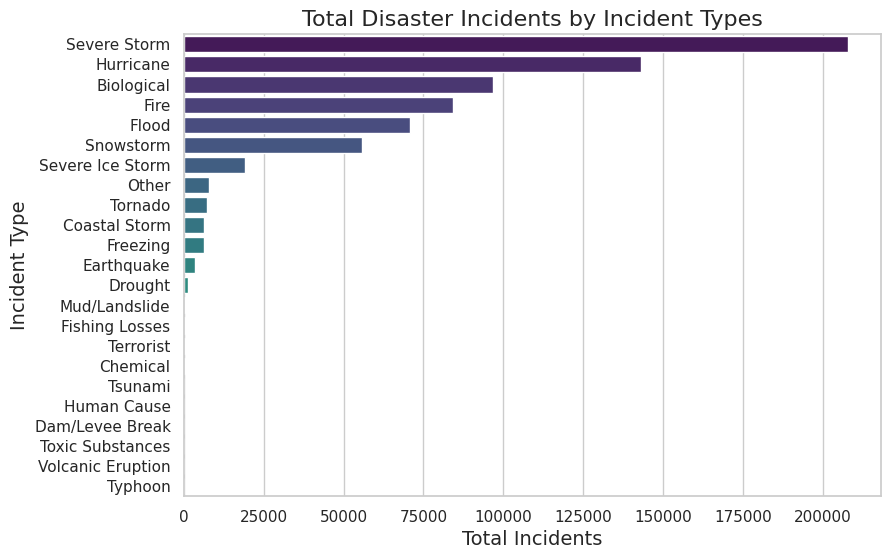

In [ ]:
# Visual of Incident Types of Frequency/Number of Incidnets

# Create a Horizontal Bar Plot
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a horizontal bar plot for total incidents by incident type
plt.figure(figsize=(9,6))
sns.barplot(
    data=higher_level_summary.sort_values('Total Incidents', ascending=False),
    y='Incident Type',
    x='Total Incidents',
    hue='Incident Type',
    palette='viridis',
    legend=False
)


# Add title and labels
plt.title('Total Disaster Incidents by Incident Types', fontsize=16)
plt.xlabel('Total Incidents', fontsize=14)
plt.ylabel('Incident Type', fontsize=14)

# Show the plot
plt.show()

#####**Observation**
The most frequent disaster types in the FEMA records are Severe Storms and Hurricanes, each with over 150,000 reported incidents, dominating all other categories. Biological and Fire incidents follow with significantly fewer counts, while a long tail of less common disasters—such as Tsunamis, Chemical incidents, and Typhoons—appear with very low frequency.

This distribution suggests that U.S. disaster preparedness and policy planning should focus most on managing storm-related events, while still accounting for a diverse range of less frequent but potentially severe incident types.


**Note on COVID-19 Impact (1990–2020):**
The spike in Biological disaster incidents is likely attributable to the COVID-19 pandemic, which began in the U.S. in early 2020. FEMA declared numerous disaster declarations nationwide in response to the pandemic, often assigning a separate record for each county or region. This led to a sharp increase in the count of biological incidents within a single year, despite such disasters being rare in the past.

#### 3.1.1.2 Bubble Chart - Total Incidents by Total Years & Incident Types

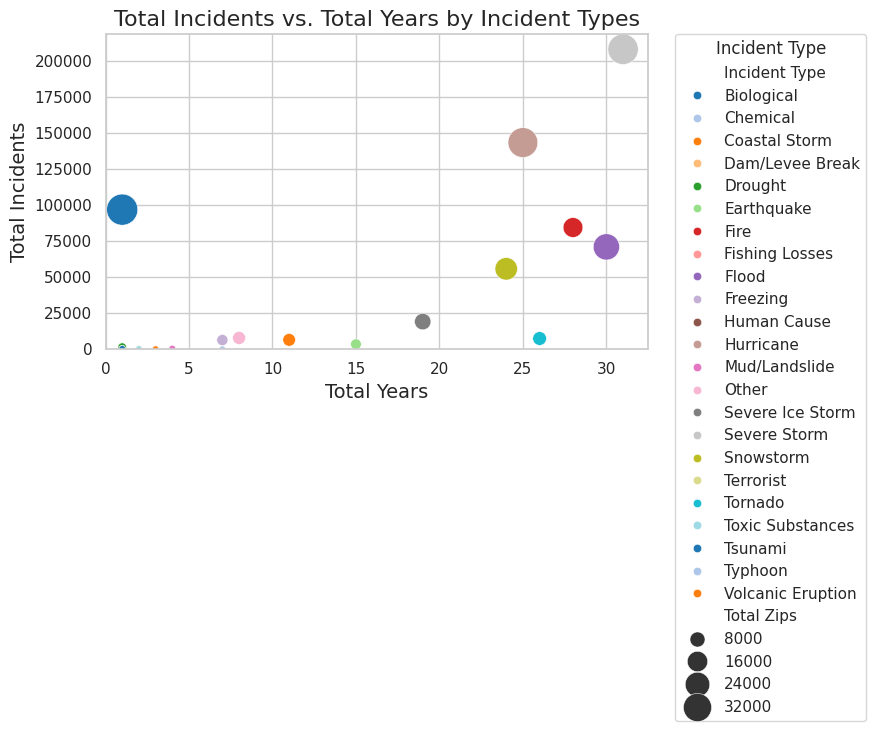

In [ ]:
# Bubble Chart with improved color clarity

import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(9, 6))
scatter_plot = sns.scatterplot(
    data=higher_level_summary,
    x='Total Years',
    y='Total Incidents',
    size='Total Zips',
    sizes=(20, 500),
    hue='Incident Type',
    palette='tab20'
)

# Add title and labels
plt.title('Total Incidents vs. Total Years by Incident Types', fontsize=16)
plt.xlabel('Total Years', fontsize=14)
plt.ylabel('Total Incidents', fontsize=14)

# Set axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Show the legend
plt.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Optimize layout
plt.tight_layout()
plt.show()


##### **Observation**

This bubble chart visualizes the relationship between the **total number of FEMA disaster incidents** (Y-axis) and the **number of years in which they occurred** (X-axis) from 1990 to 2020. The **bubble size** reflects how many unique ZIP codes were affected by each disaster type.

#### Key Insights:

- **Severe Storm** is the most dominant disaster type:
  - Occurred consistently across **all 30 years**
  - Accounts for **over 200,000 incidents**
  - Affects the **largest number of ZIP codes**, highlighting it as the most widespread and recurrent risk in the U.S.

- **Hurricane** also spans the full 30-year period with a high incident count, indicating persistent coastal vulnerability.

- **Biological disasters** show an outlier pattern:
  - Despite occurring in **only one year**, it has **nearly 100,000 incidents**, suggesting a **massive spike likely tied to COVID-19 in 2020**.
  - The bubble size and incident volume emphasize its broad geographic and systemic impact in a short time span.

- **Fire, Flood, and Snowstorm** are medium-frequency disasters:
  - Spread over 20–30 years with moderate incident counts, indicating seasonal and regional relevance.

- **Rare disasters** like **Tsunami**, **Volcanic Eruption**, and **Chemical spills** sit in the bottom-left corner:
  - They are infrequent and limited in spread but may still carry high severity when they occur.

#### Conclusion:

The FEMA data suggests that **storm-related events (Severe Storms & Hurricanes)** should be top priorities in U.S. disaster preparedness. Meanwhile, **emerging or rare risks** such as pandemics or geological events require **contingency planning** despite their lower frequency due to their potential for large-scale impact.


#### 3.1.1.3 Heatmap -- Incident Type Trends Over Time

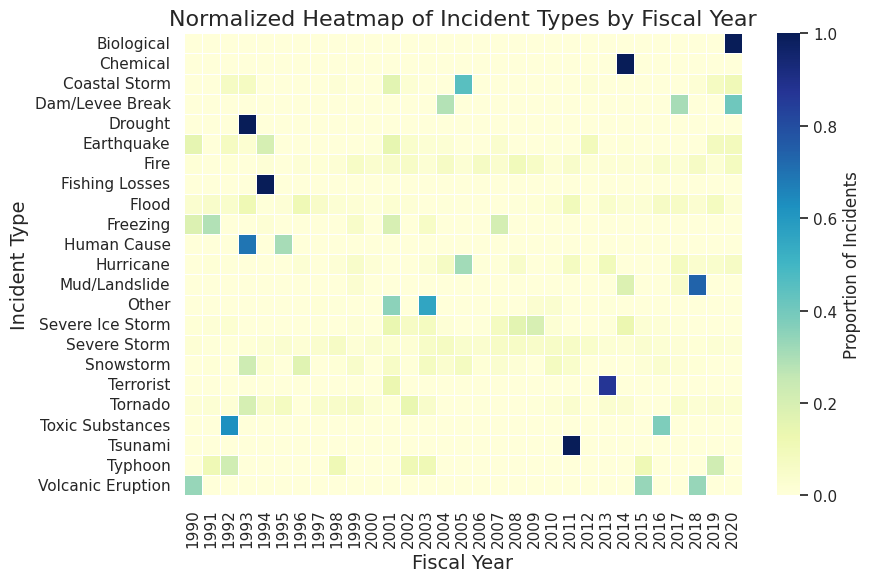

In [ ]:
# Heatmap of incident type

import matplotlib.pyplot as plt

# Create a pivot table to summarize the data
heatmap_data = fema_with_zip_MSA_df.pivot_table(
    index='incidentType',
    columns='fyDeclared',
    values='disasterNumber',
    aggfunc='count',
    fill_value=0  # Fill missing values with 0
)

# Normalize the data by dividing by the total number of incidents
normalized_heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Create the heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(normalized_heatmap_data,
            cmap='YlGnBu',
            annot=False,
            linewidths=.5,
            cbar_kws={'label': 'Proportion of Incidents'})

# Add title and labels
plt.title('Normalized Heatmap of Incident Types by Fiscal Year', fontsize=16)
plt.xlabel('Fiscal Year', fontsize=14)
plt.ylabel('Incident Type', fontsize=14)

# Show the plot
plt.show()



##### **Observations**

- **Severe Storms** are consistently present across nearly all years, reinforcing their position as the most frequent and persistent disaster type.
- **Biological** incidents have a distinct spike in **2020**, likely linked to the **COVID-19 pandemic** and its classification as a federal emergency.
- **Fires** and **Human-Caused** disasters also show notable peaks in specific years (e.g., 1994, 2002), possibly reflecting major wildfire seasons or terrorism-related events.
- **Droughts**, while rare overall, appear intensely in select years, indicating significant events with potentially wide regional impact.
- Some types such as **Tsunamis**, **Volcanic Eruptions**, and **Typhoons** are extremely sparse, only appearing in a handful of years—this aligns with their naturally rare occurrence in the U.S.

This visualization helps us understand the **temporal patterns** and **episodic nature** of certain disasters, providing insight for preparedness and historical disaster research.


### **3.1.2 Zip Code Footprint Visual in FEMA Dataframe**


#### **3.1.2.0 ZIP-Level Summary Preparation**
Summary tables were created to support ZIP-level analysis, including incident frequency, year coverage, and incident type diversity per ZIP code.

#### **3.1.2.1 K-means Clustering of High-Incident ZIP Codes**
High-incident ZIP codes were segmented into 3 clusters based on total incidents, affected years, and type diversity.

#### **3.1.2.2 Yearly Total Disaster Incidents (Bar Chart)**
This bar chart illustrates the total number of FEMA-declared disasters by year (1990–2020), color-scaled by intensity.

#### **3.1.2.3 ZIP Coverage & Incident Type Trends (Dual-Axis Line Chart)**
A dual-axis line chart reveals how the number of impacted ZIP codes, total disasters, and incident type diversity evolved over time.



#### 3.1.2.0 ZIP-Level Preparation

To enable ZIP-level disaster trend analysis, we constructed two key summary tables:

- **ZIP-Year Summary (`zip_year_summary`)**: Counts the number of disaster declarations for each ZIP code in each fiscal year, providing a temporal footprint of disaster exposure.

- **ZIP-Level Aggregated Summary (`zip_level_summary`)**: Aggregates disaster statistics for each ZIP code, including:
  - `Total Years`: Number of distinct years in which the ZIP was affected by a disaster
  - `Total Incident Types`: Number of different disaster types experienced
  - `Total Incidents`: Total number of incidents recorded

In parallel, we also summarized annual FEMA disaster trends across the U.S. by creating:

- **Yearly Summary (`yearly_summary`)**, which includes:
  - `total_incidents`: Total number of FEMA-declared disasters each year
  - `total_unique_zips`: Count of unique ZIP codes affected each year
  - `total_incident_types`: Diversity of incident types reported each year

These intermediate datasets lay the groundwork for clustering ZIP codes by risk patterns and visualizing temporal disaster dynamics.



In [ ]:
# Summary of Incidents by Zip Code and Year
zip_year_summary = fema_with_zip_MSA_df.groupby(['zip_code', 'fyDeclared']).size().reset_index(name='incident_count')
print("zip_year_summary: \n")
print(zip_year_summary)

# Group by zip code and aggregate the required metrics
zip_level_summary = fema_with_zip_MSA_df.groupby('zip_code').agg(
    total_years=('fyDeclared', 'nunique'),  # Count unique years
    total_incident_types=('incidentType', 'nunique'),  # Count unique incident types
    total_incidents=('disasterNumber', 'count')  # Count total incidents
).reset_index()

# Rename the columns for clarity (optional)
zip_level_summary.columns = ['Zip Code', 'Total Years', 'Total Incident Types', 'Total Incidents']

# Display the summary
print("\nzip_level_summary: \n")

print(zip_level_summary)

zip_year_summary: 

       zip_code  fyDeclared  incident_count
0         00501        1991               1
1         00501        1993               2
2         00501        1996               1
3         00501        1997               1
4         00501        1999               1
...         ...         ...             ...
453679    99925        2020               1
453680    99926        2020               1
453681    99927        2020               1
453682    99928        2020               2
453683    99929        2020               2

[453684 rows x 3 columns]

zip_level_summary: 

      Zip Code  Total Years  Total Incident Types  Total Incidents
0        00501           15                     7               24
1        00601           12                     5               21
2        00602            8                     4               16
3        00603            8                     4               13
4        00604            8                     4               13
.

In [ ]:
#3. Total Disaster Incidents by Year
total_incidents_by_year = fema_with_zip_MSA_df.groupby('fyDeclared').size().reset_index(name='total_incidents')
print(total_incidents_by_year)

# Group by year and compute summary
yearly_summary = fema_with_zip_MSA_df.groupby('fyDeclared').agg(
    total_unique_zips=('zip_code', 'nunique'),
    total_incident_types=('incidentType', 'nunique'),
    total_incidents=('disasterNumber', 'count')
).reset_index()

# Display the summary
print(yearly_summary)

    fyDeclared  total_incidents
0         1990             8575
1         1991             8542
2         1992             7027
3         1993            26848
4         1994             9053
5         1995             8779
6         1996            24696
7         1997            12972
8         1998            19443
9         1999            20268
10        2000            12518
11        2001            22535
12        2002            12910
13        2003            27946
14        2004            33091
15        2005            62907
16        2006            15157
17        2007            21206
18        2008            32186
19        2009            20720
20        2010            21286
21        2011            37022
22        2012            13002
23        2013            23599
24        2014             9570
25        2015            10335
26        2016            14905
27        2017            21923
28        2018            16300
29        2019            19268
30      

#### 3.1.2.1 K-means Clustering of Zips in Merged FEMA





To identify and segment ZIP codes with a high frequency of disaster declarations, we performed the following steps:

1. **Data Filtering**: Selected ZIP codes with total incident counts above the 75th percentile (threshold > 30).
2. **Feature Selection**: Used `Total Years`, `Total Incident Types`, and `Total Incidents` as clustering features.
3. **Standardization**: Normalized the features using `StandardScaler` to ensure balanced contribution.
4. **Clustering**: Applied K-means clustering (`k=3`) to group similar ZIP codes based on incident history.
5. **Visualization**: Plotted `Total Incidents` vs `Total Years`, colored by cluster assignment.
6. **Integration**: Merged cluster labels back into the full FEMA dataset for future analysis or modeling.

In [ ]:
# Check Allocation of Zips for 2020 Biological incident types

# Filter for the year 2020 and incident type 'biological'
biological_2020 = fema_with_zip_MSA_df[
    (fema_with_zip_MSA_df['fyDeclared'] == 2020) &
    (fema_with_zip_MSA_df['incidentType'] == 'Biological')
]

# Count the unique zip codes for biological incidents in 2020
unique_biological_zips_2020 = biological_2020['zip_code'].nunique()

# Calculate the total number of unique zip codes in the entire DataFrame
total_unique_zips = fema_with_zip_MSA_df['zip_code'].nunique()

# Calculate the percentage
percentage_biological_zips_2020 = (unique_biological_zips_2020 / total_unique_zips) * 100

# Display the results
print(f"Total unique zip codes with 'biological' incidents in 2020: {unique_biological_zips_2020}")
print(f"Percentage of these zip codes vs total unique zip codes: {percentage_biological_zips_2020:.2f}%")

Total unique zip codes with 'biological' incidents in 2020: 39423
Percentage of these zip codes vs total unique zip codes: 100.00%


In [ ]:
# Calculate the average & median total incidents across zip codes
average_total_incidents = zip_level_summary['Total Incidents'].mean()
median_total_incidents = zip_level_summary['Total Incidents'].median()

print("Average Total Incidents across Zip Codes:", average_total_incidents)
print("Median Total Incidents across Zip Codes:", median_total_incidents)


# Calculate the percentils of total incidents across zip codes
percentiles = [0.25, 0.5, 0.75]

# Calculate the percentiles
incident_percentiles = zip_level_summary['Total Incidents'].quantile(percentiles)

# Display the percentiles
print("Percentiles of Total Incidents across Zip Codes:")
print(incident_percentiles)

Average Total Incidents across Zip Codes: 18.07394160769094
Median Total Incidents across Zip Codes: 17.0
Percentiles of Total Incidents across Zip Codes:
0.25    12.0
0.50    17.0
0.75    22.0
Name: Total Incidents, dtype: float64


In [ ]:
# Drop previously merged columns if re-running
fema_with_zip_MSA_df = fema_with_zip_MSA_df.drop(columns=['Cluster'], errors='ignore')
fema_with_zip_MSA_df = fema_with_zip_MSA_df.drop(columns=['Zip Code'], errors='ignore')

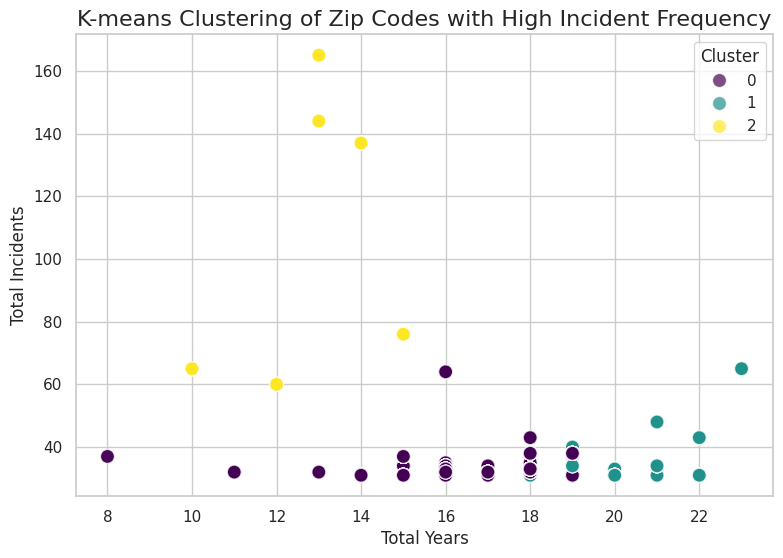

      Zip Code  Total Years  Total Incident Types  Total Incidents  Cluster
332      01431           18                     9               32        1
333      01432           18                     9               32        1
334      01434           18                     9               32        1
339      01450           18                     9               32        1
340      01451           18                     9               32        1
...        ...          ...                   ...              ...      ...
38939    98831           18                     6               43        0
38943    98836           18                     6               43        0
38950    98846           18                     6               43        0
38951    98847           18                     6               43        0
38956    98852           18                     6               43        0

[2264 rows x 5 columns]


In [ ]:
# K-means clustering analysis on zip codes with a high frequency of incidents
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Step 1: Filter the data for high frequency of incidents
threshold = 30  # Threshold [75% percentile]
high_incident_zips = zip_level_summary[zip_level_summary['Total Incidents'] > threshold]

# Step 2: Prepare the data for clustering
# Select relevant features for clustering
X = high_incident_zips[['Total Years', 'Total Incident Types', 'Total Incidents']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply K-means clustering
kmeans = KMeans(n_clusters= 3, random_state=42)  # Can updatethe number of clusters
high_incident_zips = high_incident_zips.copy()
high_incident_zips['Cluster'] = kmeans.fit_predict(X_scaled)


# Step 4: Create a mapping of zip codes to cluster labels
zip_cluster_mapping = high_incident_zips[['Zip Code', 'Cluster']]


# Step 5: Merge the cluster labels back to the original DataFrame
fema_with_zip_MSA_df = fema_with_zip_MSA_df.merge(zip_cluster_mapping,
                                                    left_on='zip_code',
                                                    right_on='Zip Code',
                                                    how='left')


# Step 6: Visualize the clusters
plt.figure(figsize=(9, 6))
sns.scatterplot(data=high_incident_zips,
                x='Total Years',
                y='Total Incidents',
                hue='Cluster',
                palette='viridis',
                s=100,
                alpha=0.7)

# Add title and labels
plt.title('K-means Clustering of Zip Codes with High Incident Frequency', fontsize=16)
plt.xlabel('Total Years', fontsize=12)
plt.ylabel('Total Incidents', fontsize=12)
plt.legend(title='Cluster')
plt.show()

# Display the clustered data
print(high_incident_zips[['Zip Code', 'Total Years', 'Total Incident Types', 'Total Incidents', 'Cluster']])

# Rename the severity column for clarity
fema_with_zip_MSA_df.rename(columns={'Severity': 'Incident Severity'}, inplace=True)





#####**Observations**

- **Cluster 2 (Yellow)**: ZIP codes in this cluster experienced extremely high numbers of incidents (some exceeding 150) but over a **shorter range of years** (around 10–15 years). These likely correspond to areas with **intense but short-lived disaster activity**, such as recurring events during a specific decade.

- **Cluster 1 (Teal)**: ZIP codes with **moderate incident frequency** (30–60)spread consistently across **20+ years**. These areas may face steady but less extreme risk exposure across multiple incident types.

- **Cluster 0 (Purple)**: ZIP codes with **lower total incidents** (mostly 30–40), even though they span **15–20 years**. These represent **stable, lower-risk areas** with distributed but infrequent events.


#### 3.1.2.2 Bar Chart - Yearly Total Disaster Incidents
This bar chart illustrates the total number of FEMA-declared disasters by year (1990–2020), color-scaled by intensity.

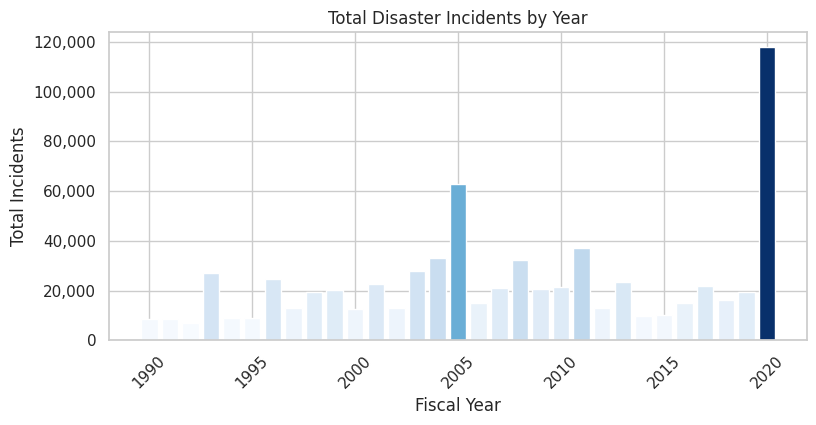

In [ ]:

from matplotlib.ticker import FuncFormatter


# Normalize the total incidents for color mapping
total_incidents_by_year['normalized'] = (total_incidents_by_year['total_incidents'] - total_incidents_by_year['total_incidents'].min()) / (total_incidents_by_year['total_incidents'].max() - total_incidents_by_year['total_incidents'].min())

# Create a colormap
cmap = plt.get_cmap('Blues')  # You can choose any single color scheme

# Create the bar plot
plt.figure(figsize=(9, 4))
bars = plt.bar(total_incidents_by_year['fyDeclared'], total_incidents_by_year['total_incidents'],
                color=cmap(total_incidents_by_year['normalized']))

# Add title and labels
plt.title('Total Disaster Incidents by Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Incidents')

# Format the y-axis to show numbers with commas
def format_func(value, tick_number):
    return f'{int(value):,}'  # Format the number with commas

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.xticks(rotation=45)

# Show the plot
plt.show()

##### **Observations**

- **2020** stands out sharply with the **highest number of disaster declarations**, exceeding **110,000 incidents**. This extreme spike is primarily attributed to the **COVID-19 pandemic**, which was declared a nationwide emergency across nearly all ZIP codes.
  
- The **second-largest spike** occurs in **2005**, likely reflecting the impact of **Hurricane Katrina** and other major storm-related events during that period.

- Other years show relatively stable counts, typically ranging between **10,000–35,000** incidents per year.

- Overall, while most years reflect a consistent trend of disaster declarations, specific years with **nationwide or high-impact events** cause visible peaks, emphasizing the episodic nature of large-scale disasters.


#### 3.1.2.3 Dual-Axis Line Chart - ZIP Coverage & Incident Type Trends

A dual-axis line chart reveals how the number of impacted ZIP codes, total disasters, and incident type diversity evolved over time.

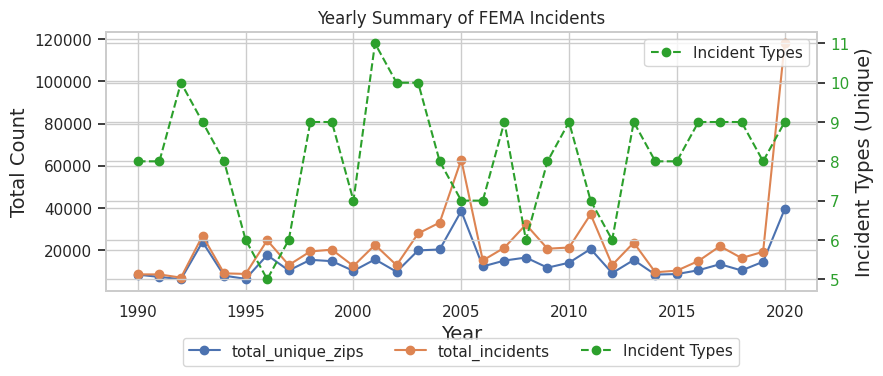

In [ ]:

# Create the plot with a primary and secondary y-axis
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot line charts on primary y-axis
yearly_summary.set_index('fyDeclared')[['total_unique_zips', 'total_incidents']].plot(
    kind='line', ax=ax1, marker='o'
)

# Customize primary y-axis
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Count', fontsize=14)
ax1.set_title('Yearly Summary of FEMA Incidents')
ax1.legend(title='Metrics', loc='upper left')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot line chart for incident types on secondary y-axis
yearly_summary.plot(
    kind='line', x='fyDeclared', y='total_incident_types', ax=ax2,
    label='Incident Types', color='tab:green', linestyle='--', marker='o'
)

# Customize secondary y-axis
ax2.set_ylabel('Incident Types (Unique)', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Create a combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Final layout
plt.tight_layout()
plt.show()

##### **Observation**

- **Total Incidents and ZIP Code Coverage** show a generally increasing trend, with noticeable peaks in **2005** and **2020**. The 2020 spike stands out dramatically, consistent with the impact of the COVID-19 pandemic.

- **2020** saw not only the highest total incidents but also the highest count of **unique ZIP codes involved**, suggesting a widespread, nationwide emergency.

- Interestingly, **the number of unique incident types** remained relatively stable across years (mostly between 6–10), even during major spikes—indicating that most disasters stem from a few recurring types (e.g., storms, fires, floods).

- The year **2005** also stands out with a surge in both incident volume and affected ZIPs, aligning with major natural disasters like Hurricane Katrina.


## Part 2: EDA on HPI Dataframe

### 3.2.1 Time Trend Analysis of HPI: Average HPI Trend by MSA and State

This section explores long-term housing price trends across U.S. regions from 1990 to 2020 by analyzing the average Housing Price Index (HPI) at two levels:

- **MSA-Level**: Aggregated HPI across Metropolitan Statistical Areas (MSAs), revealing localized market dynamics and growth hotspots.
- **State-Level**: Highlights broader regional differences in housing prices, showcasing geographic disparities and macroeconomic influences.


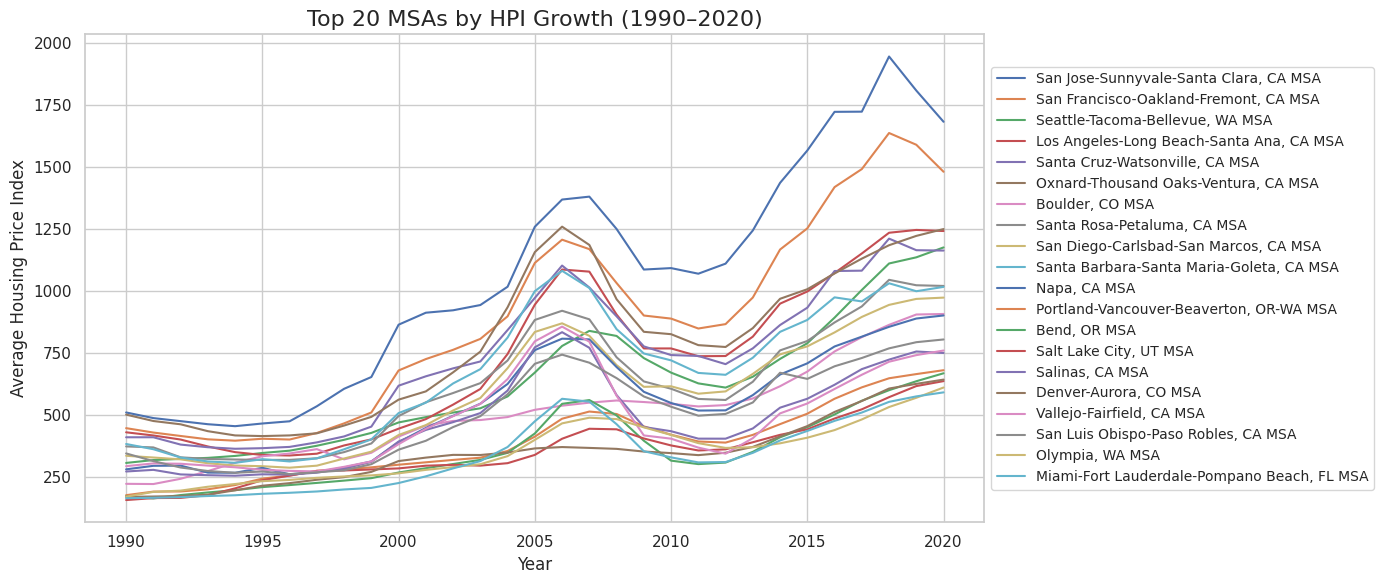

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy the original dataset
df = clean_hpi_geo_df.copy()

# Extract columns that start with 'HPI_'
hpi_cols = [col for col in df.columns if col.startswith("HPI_")]
years = [int(col.split("_")[1]) for col in hpi_cols]

# Group by MSA and calculate the mean HPI for each year
msa_grouped = df.groupby("msa_name")[hpi_cols].mean()

# Calculate HPI growth from 1990 to 2020
growth = msa_grouped["HPI_2020"] - msa_grouped["HPI_1990"]

# Select top 20 MSAs with the highest HPI growth
top_growth_msa = msa_grouped.loc[growth.sort_values(ascending=False).head(20).index]

# Plot the HPI trends for the top 5 MSAs
plt.figure(figsize=(14, 6))
for msa in top_growth_msa.index:
    plt.plot(years, top_growth_msa.loc[msa].values, label=msa)

plt.title("Top 20 MSAs by HPI Growth (1990–2020)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Housing Price Index")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()


##### **Observation**: Top 20 MSAs by HPI Growth (1990–2020)

The chart shows that the fastest-growing Housing Price Index (HPI) regions are predominantly located along the West Coast, especially in California and Washington. MSAs such as San Jose, San Francisco, and Seattle have experienced substantial price increases over the past three decades. Although there was a noticeable dip around the 2008 financial crisis, the overall trend has been steadily upward—especially post-2010—highlighting strong long-term demand and economic resilience in these areas.


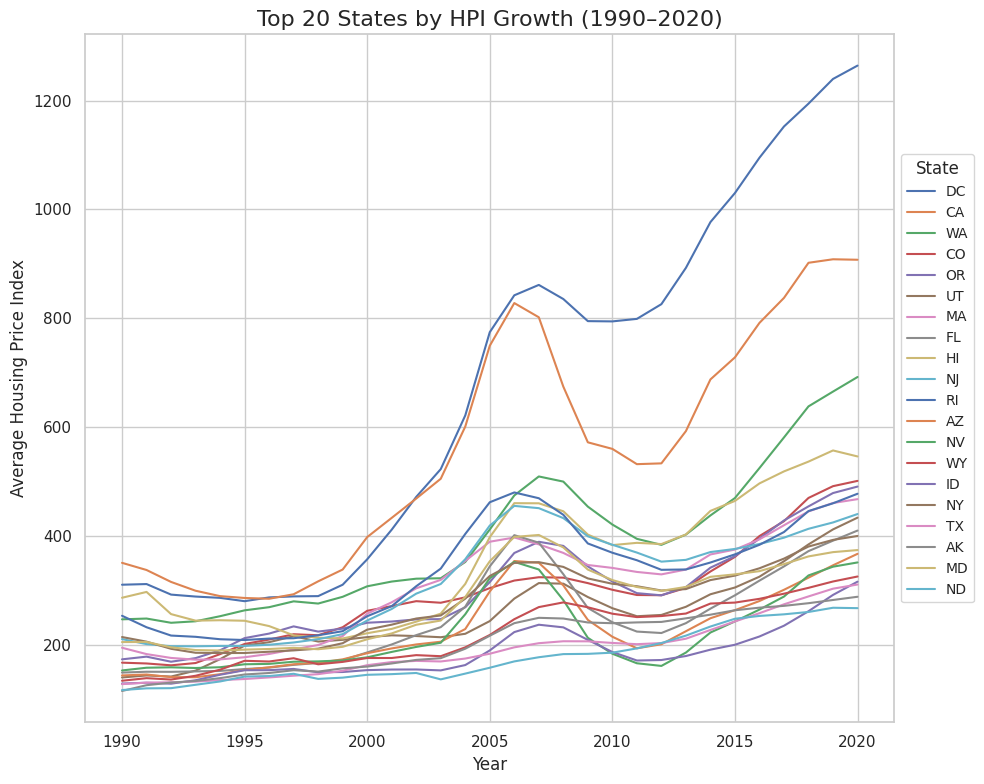

In [ ]:
## State-level Aggregation
# Compute average HPI by state for each year
state_grouped = df.groupby("state")[hpi_cols].mean()

# Calculate total HPI growth between 1990 and 2020
state_grouped["growth"] = state_grouped["HPI_2020"] - state_grouped["HPI_1990"]

# Select top 20 states with the highest HPI growth
top_20_states = state_grouped.sort_values("growth", ascending=False).head(20)

# Plot HPI trends for top 20 states
plt.figure(figsize=(10, 8))
for state in top_20_states.index:
    plt.plot(years, top_20_states.loc[state, hpi_cols].values, label=state)

plt.title("Top 20 States by HPI Growth (1990–2020)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Housing Price Index")
plt.legend(title="State", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()


#####  **Observations**: Top 20 States by HPI Growth (1990–2020)

- **Washington, D.C. (DC)** shows the most dramatic HPI growth, especially after 2010, reaching over 1200 by 2020.
- **California (CA)** and **Washington (WA)** also exhibit steep and steady increases, with temporary dips around the 2008 housing crisis.
- Most states saw accelerated growth post-2012, rebounding strongly after the recession.
- States like **North Dakota (ND)** and **Maryland (MD)** had more modest and stable growth in comparison.
- The overall trend highlights **increased housing demand and price inflation** in urban or coastal states.


### 3.2.2 Time Trend Analysis of HPI: Volatility in Housing Price Growth (1990–2020)

This section analyzes the volatility of annual housing price growth across U.S. MSAs from 1990 to 2020. By calculating the standard deviation of annual HPI changes, we identify regions with the most unstable price trends. Peaks in volatility correspond to known housing market disruptions (e.g., 2005 pre-crisis, 2018 corrections). Notably, many of the most volatile areas are non-metropolitan regions, suggesting greater sensitivity to economic fluctuations and housing demand shocks.



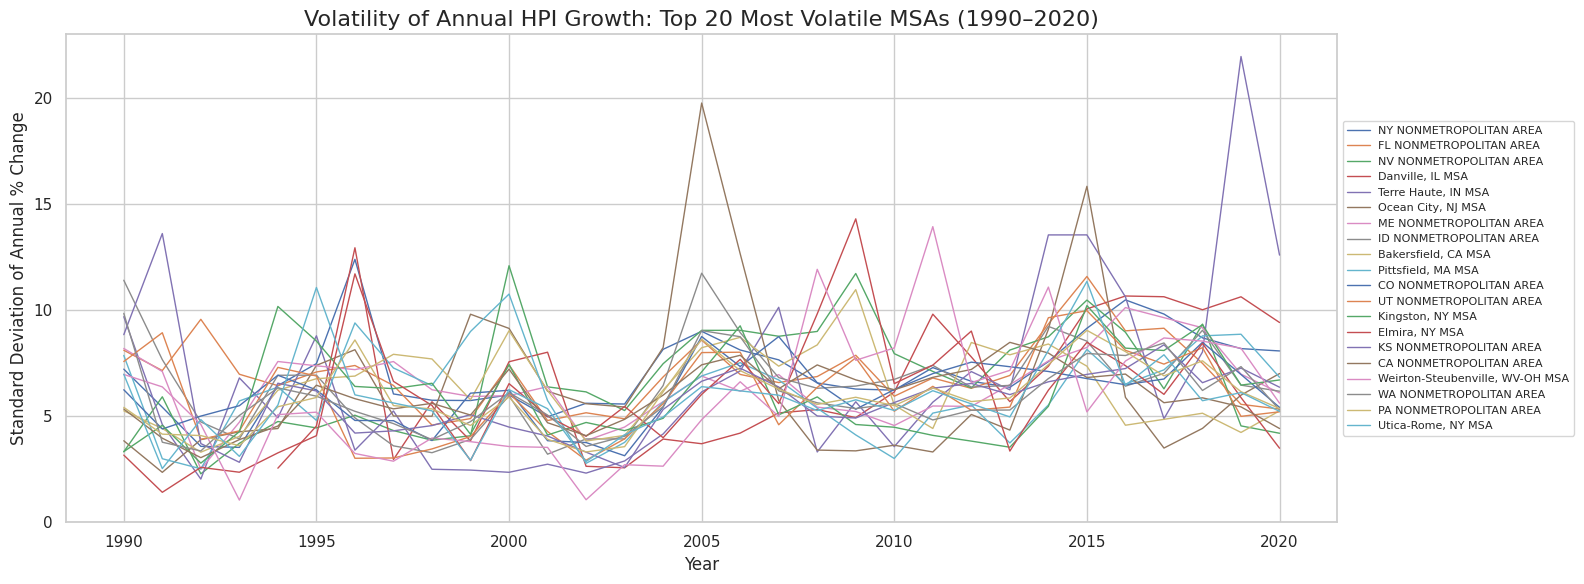

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract annual change columns
change_cols = [col for col in clean_hpi_geo_df.columns if col.startswith("annual_change_")]
years = [int(col.split("_")[2]) for col in change_cols]

# Group by MSA and calculate standard deviation of annual change
msa_std = clean_hpi_geo_df.groupby('msa_name')[change_cols].std()

# Get top 20 most volatile MSAs
top_20_msa_std = msa_std.mean(axis=1).sort_values(ascending=False).head(20).index

# Filter for top 20 MSAs only
top_20_std_df = msa_std.loc[top_20_msa_std]

# Plot
plt.figure(figsize=(16, 6))  # wider figure
for msa in top_20_std_df.index:
    plt.plot(years, top_20_std_df.loc[msa].values, label=msa, linewidth=1)  # thinner lines

plt.title("Volatility of Annual HPI Growth: Top 20 Most Volatile MSAs (1990–2020)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Standard Deviation of Annual % Change")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)  # shrink legend text
plt.grid(True)
plt.tight_layout()
plt.show()





##### **Observations**

- These MSAs show **high year-to-year fluctuations** in housing price growth.  
- Volatility peaks around **1996**, **2005**, and **2018**, aligning with major housing market cycles.  
- Many **non-metropolitan areas** (e.g., NY, FL, NV) are among the most volatile.  
- These regions may be **more sensitive to economic shifts** or have **less stable housing demand**.


## Part 3: EDA on Final Merged Dataset: Housing, Disasters, and Demographics (`fema_hpi_demo_df`)

### 3.3.0 Merging HPI with Demographic and FEMA dataframe


In this section, we combined three cleaned datasets—**HPI data**, **FEMA disaster data**, and **county-level demographics**—into a single unified dataframe: `fema_hpi_demo_df`.

The merging process followed these steps:
- **ZIP–FIPS standardization** was applied to ensure geographic consistency.
- **HPI data** was enriched with FEMA disaster summaries (incident counts and clusters) per ZIP and year.
- **County-level demographic data** was merged using ZIP and year as keys.
- Nulls in essential fields (e.g., `HPI`, `incident_types`, `caucasian_population_ratio`) were dropped to ensure data quality.

The resulting dataset (`fema_hpi_demo_df`) integrates economic, disaster, and demographic dimensions, enabling comprehensive ZIP-level analysis across time.


Review of All Cleaned Dataframes for Overall Merging

In [ ]:
county_demographics_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212519 entries, 0 to 1212518
Data columns (total 22 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   year                               1212519 non-null  int64  
 1   fips                               1212519 non-null  int64  
 2   caucasion_population_ratio         1212519 non-null  float64
 3   African-American_population_ratio  1212519 non-null  float64
 4   other_race_population_ratio        1212519 non-null  float64
 5   non-Hispanic_population_ratio      1212519 non-null  float64
 6   hispanic_population_ratio          1212519 non-null  float64
 7   male_population_ratio              1212519 non-null  float64
 8   female_population_ratio            1212519 non-null  float64
 9   age_0_to_19_population_ratio       1212519 non-null  float64
 10  age_20_to_39_population_ratio      1212519 non-null  float64
 11  age_40_to_59_population_

In [ ]:
fema_with_zip_MSA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712529 entries, 0 to 712528
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   disasterNumber   712529 non-null  int64              
 1   designatedArea   712529 non-null  object             
 2   declarationDate  712529 non-null  datetime64[ns, UTC]
 3   fyDeclared       712529 non-null  int64              
 4   incidentType     712529 non-null  object             
 5   fipsStateCode    712529 non-null  int64              
 6   fipsCountyCode   712529 non-null  int64              
 7   fips             712529 non-null  object             
 8   zip_code         712529 non-null  object             
 9   zip_no           712529 non-null  int64              
 10  msa_name         712529 non-null  object             
 11  county_no        712529 non-null  int64              
 12  county_name      712529 non-null  object             
 13 

In [ ]:
cleaned_hpi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507056 entries, 0 to 512395
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   zip_code       507056 non-null  object 
 1   Year           507056 non-null  int64  
 2   annual_change  493590 non-null  float64
 3   HPI            507056 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 19.3+ MB


In [ ]:
# Deduplicate zip_fips mapping
zip_fips_df_dedup = zip_fips_df.sort_values(by=["zip", "fips_string"]).drop_duplicates(subset=["zip"], keep="first")
zip_fips_df_dedup["zip_code"] = zip_fips_df_dedup["zip"].apply(lambda x: f"{int(x):05}")
zip_fips_df_dedup = zip_fips_df_dedup.drop(columns=["zip"])  # drop redundant

# Merge HPI with geographic info
hpi_with_geo = pd.merge(cleaned_hpi_df, zip_fips_df_dedup, on="zip_code", how="left")

# Prepare FEMA disaster summary
fema_with_zip_MSA_df["Year"] = fema_with_zip_MSA_df["declarationDate"].dt.year
fema_summary = fema_with_zip_MSA_df.groupby(["zip_code", "Year"]).agg(
    disaster_count=("disasterNumber", "count"),
    incident_types=("incidentType", lambda x: ",".join(sorted(x.unique()))),
    clusters=("Cluster", lambda x: ",".join(map(str, sorted(x.unique()))))
).reset_index()

# Standardize demographics column name
if "year" in county_demographics_merged_df.columns:
    county_demographics_merged_df = county_demographics_merged_df.rename(columns={"year": "Year"})

# Merge HPI+geo with FEMA
merged_hpi_fema = pd.merge(hpi_with_geo, fema_summary, on=["zip_code", "Year"], how="left")

# Merge with demographics
merged_all = pd.merge(merged_hpi_fema, county_demographics_merged_df, on=["zip_code", "Year"], how="left")

# drop duplicates if any
merged_all = merged_all.drop_duplicates(subset=["zip_code", "Year"])

merged_all.head()


,zip_code,Year,annual_change,HPI,county_name_x,state_x,stcountyfp_x,fips_string_x,disaster_count,incident_types,...,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio,zip_no,msa_name,county_no,county_name_y,state_y,stcountyfp_y,fips_string_y
0,01001,1990,-1.51,191.16,Hampden County,MA,25013.0,25013,NaN,NaN,...,0.20511,0.15872,0.03454,1001.0,"Springfield, MA MSA",13.0,Hampden County,MA,25013.0,25013
1,01001,1991,-5.50,180.65,Hampden County,MA,25013.0,25013,1.0,Hurricane,...,0.20767,0.15777,0.03564,1001.0,"Springfield, MA MSA",13.0,Hampden County,MA,25013.0,25013
2,01001,1992,-1.56,177.84,Hampden County,MA,25013.0,25013,NaN,NaN,...,0.21195,0.15644,0.03661,1001.0,"Springfield, MA MSA",13.0,Hampden County,MA,25013.0,25013
3,01001,1993,0.56,178.84,Hampden County,MA,25013.0,25013,1.0,Snowstorm,...,0.21677,0.15398,0.03746,1001.0,"Springfield, MA MSA",13.0,Hampden County,MA,25013.0,25013
4,01001,1994,-3.05,173.39,Hampden County,MA,25013.0,25013,NaN,NaN,...,0.22244,0.15166,0.03836,1001.0,"Springfield, MA MSA",13.0,Hampden County,MA,25013.0,25013


In [ ]:
merged_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507056 entries, 0 to 507055
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   zip_code                           507056 non-null  object 
 1   Year                               507056 non-null  int64  
 2   annual_change                      493590 non-null  float64
 3   HPI                                507056 non-null  float64
 4   county_name_x                      506844 non-null  object 
 5   state_x                            506844 non-null  object 
 6   stcountyfp_x                       506844 non-null  float64
 7   fips_string_x                      506844 non-null  object 
 8   disaster_count                     195635 non-null  float64
 9   incident_types                     195635 non-null  object 
 10  clusters                           195635 non-null  object 
 11  fips                               5050

In [ ]:
# Drop redundant columns
fema_hpi_demo_df = merged_all.drop(columns=[
    "county_name_y", "state_y", "stcountyfp_y", "fips_string_y",
    "zip_no", "county_no", "stcountyfp_x", "fips_string_x"
])

# Rename columns
fema_hpi_demo_df = fema_hpi_demo_df.rename(columns={
    "county_name_x": "county_name",
    "state_x": "state",
})

# Check result
fema_hpi_demo_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507056 entries, 0 to 507055
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   zip_code                           507056 non-null  object 
 1   Year                               507056 non-null  int64  
 2   annual_change                      493590 non-null  float64
 3   HPI                                507056 non-null  float64
 4   county_name                        506844 non-null  object 
 5   state                              506844 non-null  object 
 6   disaster_count                     195635 non-null  float64
 7   incident_types                     195635 non-null  object 
 8   clusters                           195635 non-null  object 
 9   fips                               505001 non-null  float64
 10  caucasion_population_ratio         505001 non-null  float64
 11  African-American_population_ratio  5050

In [ ]:
print("Final merged DataFrame shape:", fema_hpi_demo_df.shape)
fema_hpi_demo_df.head(100)

Final merged DataFrame shape: (507056, 23)


,zip_code,Year,annual_change,HPI,county_name,state,disaster_count,incident_types,clusters,fips,...,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio,msa_name
0,01001,1990,-1.51,191.16,Hampden County,MA,NaN,NaN,NaN,25013.0,...,0.89901,0.10099,0.47560,0.52440,0.28107,0.32055,0.20511,0.15872,0.03454,"Springfield, MA MSA"
1,01001,1991,-5.50,180.65,Hampden County,MA,1.0,Hurricane,nan,25013.0,...,0.89430,0.10570,0.47588,0.52412,0.28056,0.31835,0.20767,0.15777,0.03564,"Springfield, MA MSA"
2,01001,1992,-1.56,177.84,Hampden County,MA,NaN,NaN,NaN,25013.0,...,0.88970,0.11030,0.47639,0.52361,0.28028,0.31472,0.21195,0.15644,0.03661,"Springfield, MA MSA"
3,01001,1993,0.56,178.84,Hampden County,MA,1.0,Snowstorm,nan,25013.0,...,0.88495,0.11505,0.47659,0.52341,0.28308,0.30872,0.21677,0.15398,0.03746,"Springfield, MA MSA"
4,01001,1994,-3.05,173.39,Hampden County,MA,NaN,NaN,NaN,25013.0,...,0.88068,0.11932,0.47696,0.52304,0.28504,0.30250,0.22244,0.15166,0.03836,"Springfield, MA MSA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,01007,1994,-1.07,151.84,Hampshire County,MA,NaN,NaN,NaN,25015.0,...,0.97074,0.02926,0.47038,0.52962,0.26955,0.35825,0.21849,0.12347,0.03023,"Springfield, MA MSA"
96,01007,1995,0.60,152.76,Hampshire County,MA,NaN,NaN,NaN,25015.0,...,0.96988,0.03012,0.46956,0.53044,0.27069,0.35006,0.22572,0.12218,0.03135,"Springfield, MA MSA"
97,01007,1996,1.46,154.99,Hampshire County,MA,1.0,Snowstorm,nan,25015.0,...,0.96929,0.03071,0.46843,0.53157,0.27096,0.34195,0.23452,0.12029,0.03226,"Springfield, MA MSA"
98,01007,1997,1.09,156.68,Hampshire County,MA,NaN,NaN,NaN,25015.0,...,0.96850,0.03150,0.46792,0.53208,0.26971,0.33409,0.24412,0.11880,0.03329,"Springfield, MA MSA"


In [ ]:
# Check for null values in each column
null_counts = fema_hpi_demo_df.isnull().sum()

# Display the count of null values for each column
print(null_counts)

zip_code                                  0
Year                                      0
annual_change                         13466
HPI                                       0
county_name                             212
state                                   212
disaster_count                       311421
incident_types                       311421
clusters                             311421
fips                                   2055
caucasion_population_ratio             2055
African-American_population_ratio      2055
other_race_population_ratio            2055
non-Hispanic_population_ratio          2055
hispanic_population_ratio              2055
male_population_ratio                  2055
female_population_ratio                2055
age_0_to_19_population_ratio           2055
age_20_to_39_population_ratio          2055
age_40_to_59_population_ratio          2055
age_60_to_79_population_ratio          2055
age_80_and_over_population_ratio       2055
msa_name                        

In [ ]:
# Drop rows with Null Values: Incident Types, HPI, Demographic (e.g., )

# Drop rows where 'incidentType' is null & reset the index
fema_hpi_demo_df = fema_hpi_demo_df.dropna(subset=['incident_types']).reset_index(drop=True)
fema_hpi_demo_df = fema_hpi_demo_df.dropna(subset=['HPI']).reset_index(drop=True)
fema_hpi_demo_df = fema_hpi_demo_df.dropna(subset=['caucasion_population_ratio']).reset_index(drop=True)


# Display the updated DataFrame
print(fema_hpi_demo_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195311 entries, 0 to 195310
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   zip_code                           195311 non-null  object 
 1   Year                               195311 non-null  int64  
 2   annual_change                      190675 non-null  float64
 3   HPI                                195311 non-null  float64
 4   county_name                        195311 non-null  object 
 5   state                              195311 non-null  object 
 6   disaster_count                     195311 non-null  float64
 7   incident_types                     195311 non-null  object 
 8   clusters                           195311 non-null  object 
 9   fips                               195311 non-null  float64
 10  caucasion_population_ratio         195311 non-null  float64
 11  African-American_population_ratio  1953

In [ ]:
# Check for null values in each column
null_counts = fema_hpi_demo_df.isnull().sum()

# Display the count of null values for each column
print(null_counts)

zip_code                                0
Year                                    0
annual_change                        4636
HPI                                     0
county_name                             0
state                                   0
disaster_count                          0
incident_types                          0
clusters                                0
fips                                    0
caucasion_population_ratio              0
African-American_population_ratio       0
other_race_population_ratio             0
non-Hispanic_population_ratio           0
hispanic_population_ratio               0
male_population_ratio                   0
female_population_ratio                 0
age_0_to_19_population_ratio            0
age_20_to_39_population_ratio           0
age_40_to_59_population_ratio           0
age_60_to_79_population_ratio           0
age_80_and_over_population_ratio        0
msa_name                                0
dtype: int64


In [ ]:
fema_hpi_demo_df.head(25)

,zip_code,Year,annual_change,HPI,county_name,state,disaster_count,incident_types,clusters,fips,...,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio,msa_name
0,01001,1991,-5.50,180.65,Hampden County,MA,1.0,Hurricane,nan,25013.0,...,0.89430,0.10570,0.47588,0.52412,0.28056,0.31835,0.20767,0.15777,0.03564,"Springfield, MA MSA"
1,01001,1993,0.56,178.84,Hampden County,MA,1.0,Snowstorm,nan,25013.0,...,0.88495,0.11505,0.47659,0.52341,0.28308,0.30872,0.21677,0.15398,0.03746,"Springfield, MA MSA"
2,01001,1996,0.12,176.91,Hampden County,MA,1.0,Snowstorm,nan,25013.0,...,0.87070,0.12930,0.47750,0.52250,0.28746,0.28958,0.23503,0.14773,0.04019,"Springfield, MA MSA"
3,01001,2003,8.49,241.94,Hampden County,MA,1.0,Snowstorm,nan,25013.0,...,0.83261,0.16739,0.47923,0.52077,0.28502,0.25655,0.27624,0.13732,0.04487,"Springfield, MA MSA"
4,01001,2004,12.14,271.31,Hampden County,MA,1.0,Snowstorm,nan,25013.0,...,0.82775,0.17225,0.47957,0.52043,0.28278,0.25375,0.28030,0.13746,0.04571,"Springfield, MA MSA"
5,01001,2005,17.25,318.11,Hampden County,MA,3.0,"Hurricane,Severe Storm,Snowstorm",nan,25013.0,...,0.82316,0.17684,0.47999,0.52001,0.28023,0.25175,0.28397,0.13731,0.04675,"Springfield, MA MSA"
6,01001,2007,-0.28,327.77,Hampden County,MA,1.0,Severe Storm,nan,25013.0,...,0.81058,0.18942,0.48026,0.51974,0.27659,0.24868,0.28552,0.14120,0.04802,"Springfield, MA MSA"
7,01001,2008,-0.51,326.11,Hampden County,MA,1.0,Severe Storm,nan,25013.0,...,0.80359,0.19641,0.48049,0.51951,0.27491,0.24746,0.28472,0.14470,0.04822,"Springfield, MA MSA"
8,01001,2009,-3.97,313.18,Hampden County,MA,1.0,Severe Ice Storm,nan,25013.0,...,0.79644,0.20356,0.48062,0.51938,0.27269,0.24756,0.28392,0.14796,0.04789,"Springfield, MA MSA"
9,01001,2011,-2.63,299.03,Hampden County,MA,5.0,"Hurricane,Severe Storm,Snowstorm,Tornado",nan,25013.0,...,0.78403,0.21597,0.48123,0.51877,0.26707,0.24990,0.28124,0.15454,0.04725,"Springfield, MA MSA"


#### **Final Output**: `fema_hpi_demo_df`

- **Rows**: 195,311  
- **Columns**: 23  
- **Content**: A unified ZIP-level panel dataset combining housing price trends, disaster frequency, and demographic composition.

#### Key Features:
- **HPI Metrics**: `HPI`, `annual_change` capturing local housing price levels and year-over-year growth.
- **Disaster Data**: `disaster_count`, `incident_types`, and `clusters` summarize FEMA disaster declarations by ZIP and year.
- **Demographic Attributes**: Includes racial, ethnic, gender, and age group ratios derived from county-level data.
- **Geographic Identifiers**: ZIP code, county name, state, FIPS, and MSA.

This final dataset enables comprehensive analysis of housing market behavior, disaster vulnerability, and demographic characteristics at the ZIP-year level across the U.S. from 1990 to 2020.


### 3.3.1 One-Hot Encoding for FEMA Incident Types

In this step, we enhanced the merged FEMA-HPI-Demographic dataset by one-hot encoding the `incident_types` field to prepare for analysis across disaster categories.

1. **Preprocessing**: We split the `incident_types` string column into a list of types for each ZIP-year record.
2. **Exploding**: The list was exploded to generate one row per disaster type, enabling categorical transformation.
3. **One-Hot Encoding**: Using `pd.get_dummies()`, we encoded each unique disaster type into its own binary column (e.g., `disaster_Flood`, `disaster_Fire`).
4. **Aggregation**: We grouped the one-hot encoded data by ZIP code and Year, summing the binary flags to count the presence of each disaster type.
5. **Merging**: The aggregated one-hot encoded columns were merged back into the original dataset.
6. **Cleaning**: Redundant columns were dropped, and columns were renamed for consistency (e.g., `disaster_count_x` → `disaster_count`).

The final dataset, `full_encoded_df`, is now ready for advanced analysis with each disaster type represented as a feature, enabling more granular EDA and machine learning applications.



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of the claned fema dataframe
filtered_df = fema_hpi_demo_df.copy()


# Split disaster types into list
filtered_df['incident_types_list'] = filtered_df['incident_types'].str.split(',')

# Explode the list to create a row for each incident type
exploded_df = filtered_df.explode('incident_types_list')

# Perform one-hot encoding on the exploded column
one_hot_df = pd.get_dummies(exploded_df, columns=['incident_types_list'], prefix='disaster')

# Group by zip_code & Year, aggregate the one-hot encoded columns
aggregated_one_hot_df = one_hot_df.groupby(['zip_code', 'Year'], as_index=False).agg({
    **{col: 'sum' for col in one_hot_df.columns if col.startswith('disaster_')}
})

## UPDATED CODES ##
# Merge the aggregated one-hot encoded columns back with the original DataFrame
encoded_fema_annual_change_df = pd.merge(
    filtered_df.drop(columns=['incident_types_list']),  # Drop the temporary list column
    aggregated_one_hot_df,
    on=['zip_code', 'Year'],
    how='left'
)

# Display the updated DataFrame
print(encoded_fema_annual_change_df.head())


# # Print preview
# print("Encoded FEMA + HPI demo DataFrame:")
# print(encoded_fema_annual_change_df.head())
# print(f"Shape: {encoded_fema_annual_change_df.shape}")

  zip_code  Year  annual_change     HPI     county_name state  \
0    01001  1991          -5.50  180.65  Hampden County    MA   
1    01001  1993           0.56  178.84  Hampden County    MA   
2    01001  1996           0.12  176.91  Hampden County    MA   
3    01001  2003           8.49  241.94  Hampden County    MA   
4    01001  2004          12.14  271.31  Hampden County    MA   

   disaster_count_x incident_types clusters     fips  ...  \
0               1.0      Hurricane      nan  25013.0  ...   
1               1.0      Snowstorm      nan  25013.0  ...   
2               1.0      Snowstorm      nan  25013.0  ...   
3               1.0      Snowstorm      nan  25013.0  ...   
4               1.0      Snowstorm      nan  25013.0  ...   

   disaster_Mud/Landslide  disaster_Other  disaster_Severe Ice Storm  \
0                       0               0                          0   
1                       0               0                          0   
2                       0 

In [ ]:
encoded_fema_annual_change_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195311 entries, 0 to 195310
Data columns (total 46 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   zip_code                           195311 non-null  object 
 1   Year                               195311 non-null  int64  
 2   annual_change                      190675 non-null  float64
 3   HPI                                195311 non-null  float64
 4   county_name                        195311 non-null  object 
 5   state                              195311 non-null  object 
 6   disaster_count_x                   195311 non-null  float64
 7   incident_types                     195311 non-null  object 
 8   clusters                           195311 non-null  object 
 9   fips                               195311 non-null  float64
 10  caucasion_population_ratio         195311 non-null  float64
 11  African-American_population_ratio  1953

In [ ]:
full_encoded_df = encoded_fema_annual_change_df.copy()

full_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195311 entries, 0 to 195310
Data columns (total 46 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   zip_code                           195311 non-null  object 
 1   Year                               195311 non-null  int64  
 2   annual_change                      190675 non-null  float64
 3   HPI                                195311 non-null  float64
 4   county_name                        195311 non-null  object 
 5   state                              195311 non-null  object 
 6   disaster_count_x                   195311 non-null  float64
 7   incident_types                     195311 non-null  object 
 8   clusters                           195311 non-null  object 
 9   fips                               195311 non-null  float64
 10  caucasion_population_ratio         195311 non-null  float64
 11  African-American_population_ratio  1953

In [ ]:
columns_to_drop = [
    'disaster_count_y', 'incident_types'
]
full_encoded_df = full_encoded_df.drop(columns=columns_to_drop)

full_encoded_df = full_encoded_df.rename(columns={'disaster_count_x': 'disaster_count'})
full_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195311 entries, 0 to 195310
Data columns (total 44 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   zip_code                           195311 non-null  object 
 1   Year                               195311 non-null  int64  
 2   annual_change                      190675 non-null  float64
 3   HPI                                195311 non-null  float64
 4   county_name                        195311 non-null  object 
 5   state                              195311 non-null  object 
 6   disaster_count                     195311 non-null  float64
 7   clusters                           195311 non-null  object 
 8   fips                               195311 non-null  float64
 9   caucasion_population_ratio         195311 non-null  float64
 10  African-American_population_ratio  195311 non-null  float64
 11  other_race_population_ratio        1953

In [ ]:
# Re-arrange data by zip and then by year

# Sort the DataFrame by 'zip_code' and then by 'Year'
full_encoded_df = full_encoded_df.sort_values(by=['zip_code', 'Year'])

# Reset the index to reflect the new order
full_encoded_df = full_encoded_df.reset_index(drop=True)



In [ ]:
full_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195311 entries, 0 to 195310
Data columns (total 44 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   zip_code                           195311 non-null  object 
 1   Year                               195311 non-null  int64  
 2   annual_change                      190675 non-null  float64
 3   HPI                                195311 non-null  float64
 4   county_name                        195311 non-null  object 
 5   state                              195311 non-null  object 
 6   disaster_count                     195311 non-null  float64
 7   clusters                           195311 non-null  object 
 8   fips                               195311 non-null  float64
 9   caucasion_population_ratio         195311 non-null  float64
 10  African-American_population_ratio  195311 non-null  float64
 11  other_race_population_ratio        1953

In [ ]:
print(full_encoded_df.head(5))

  zip_code  Year  annual_change     HPI     county_name state  disaster_count  \
0    01001  1991          -5.50  180.65  Hampden County    MA             1.0   
1    01001  1993           0.56  178.84  Hampden County    MA             1.0   
2    01001  1996           0.12  176.91  Hampden County    MA             1.0   
3    01001  2003           8.49  241.94  Hampden County    MA             1.0   
4    01001  2004          12.14  271.31  Hampden County    MA             1.0   

  clusters     fips  caucasion_population_ratio  ...  disaster_Mud/Landslide  \
0      nan  25013.0                     0.90386  ...                       0   
1      nan  25013.0                     0.89773  ...                       0   
2      nan  25013.0                     0.89290  ...                       0   
3      nan  25013.0                     0.87391  ...                       0   
4      nan  25013.0                     0.87086  ...                       0   

   disaster_Other  disaster_Seve

#### Final Output: `full_encoded_df`

- **Rows**: 206,544  
- **Columns**: 44  
- **Content**: This comprehensive dataset integrates ZIP-level information on:
  - **Housing Trends**: `HPI`, `annual_change` (1990–2020)
  - **FEMA Disaster History**: `disaster_count`, `clusters`, and 22 one-hot encoded incident type columns (e.g., `disaster_Fire`, `disaster_Flood`, etc.)
  - **Demographics**: Population ratios by race, gender, age group, and ethnicity
  - **Geography**: ZIP code, county, state, MSA, FIPS

The `full_encoded_df` provides a unified view of ZIP-level housing price trends, disaster exposure, and demographic characteristics—ready for downstream modeling and EDA.


### 3.3.2 Correlation Analysis of Housing Price Index and Disaster/Demographic Factors

####  3.3.2.1 Correlation of Demographics, Disaster Frequency, and Housing Price Index

This heatmap visualizes the correlation between the Housing Price Index (HPI), disaster-related metrics (disaster_count, clusters), and key demographic variables across ZIP codes. It helps identify patterns between population characteristics and housing price trends in disaster-prone areas.



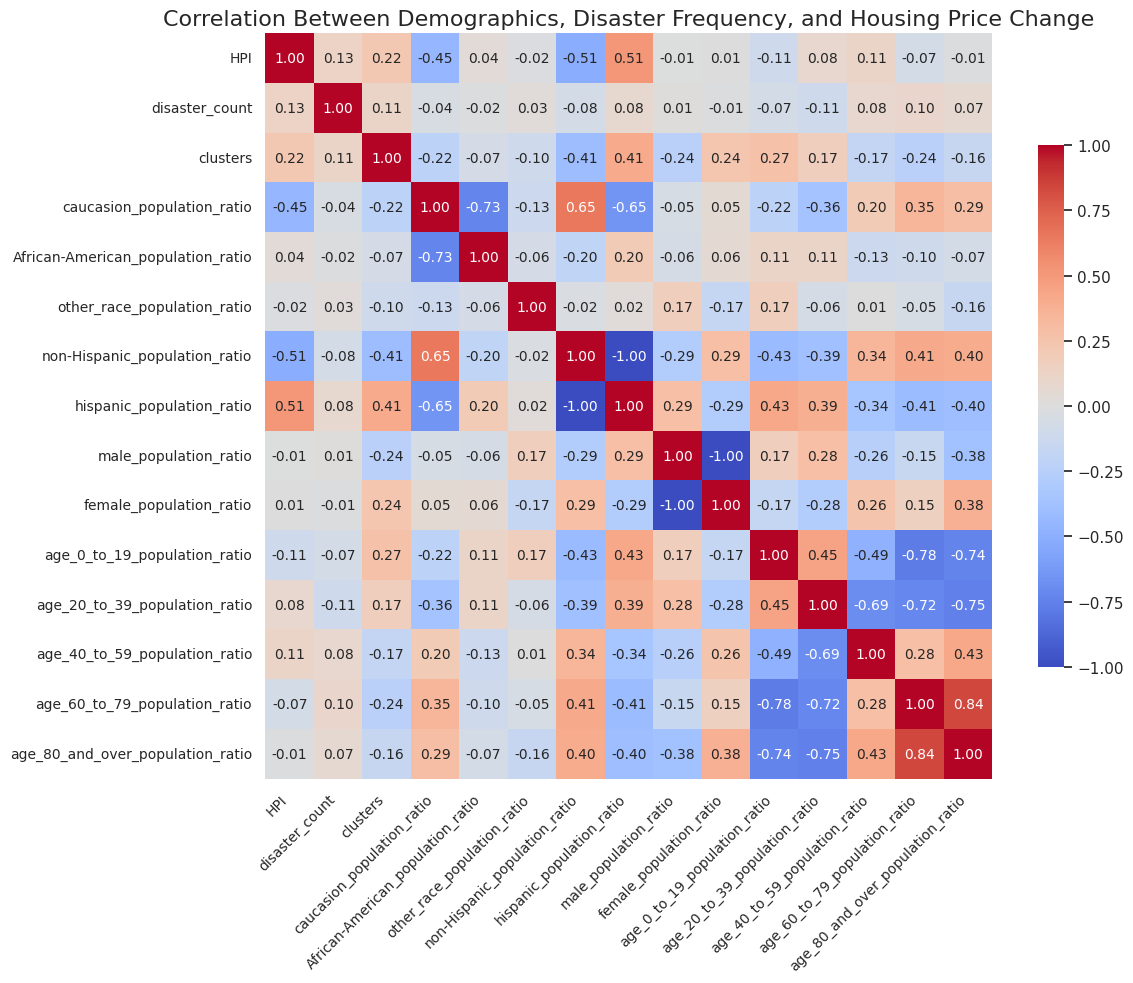

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select relevant columns for correlation analysis

full_encoded_df['clusters'] = pd.to_numeric(full_encoded_df['clusters'], errors='coerce')

correlation_columns = [
    'HPI', 'disaster_count', 'clusters',
    'caucasion_population_ratio', 'African-American_population_ratio',
    'other_race_population_ratio', 'non-Hispanic_population_ratio',
    'hispanic_population_ratio', 'male_population_ratio',
    'female_population_ratio', 'age_0_to_19_population_ratio',
    'age_20_to_39_population_ratio', 'age_40_to_59_population_ratio',
    'age_60_to_79_population_ratio', 'age_80_and_over_population_ratio'
]


# Step 2: Drop rows with missing values
correlation_data = full_encoded_df[correlation_columns].dropna()

# Step 3: Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Step 4: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Between Demographics, Disaster Frequency, and Housing Price Change", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


##### **Observations**

- **HPI and Race Composition**:
  - `HPI` shows a moderate **negative correlation** with `non-Hispanic_population_ratio` (-0.51) and `caucasion_population_ratio` (-0.45).
  - In contrast, there is a **positive correlation** between `HPI` and `hispanic_population_ratio` (0.51), suggesting areas with higher Hispanic populations may experience higher housing prices.

- **HPI and Age Demographics**:
  - `HPI` has a weak **negative correlation** with younger age groups such as `age_0_to_19_population_ratio` (-0.11) and a weak **positive correlation** with `age_20_to_39_population_ratio` (0.08).
  - Age variables show strong internal correlations (e.g., older age groups are strongly negatively correlated with younger ones), indicating potential multicollinearity.

- **Disaster Frequency and Cluster Risk**:
  - `disaster_count` has a **weak positive correlation** with `HPI` (0.13), implying minimal direct impact of disaster frequency on housing prices.
  - `clusters` (risk-based zip code clustering) shows a **mild positive correlation** with `HPI` (0.22), potentially indicating that some higher-risk areas may still have elevated property values.

#### 3.3.2.2 Correlations of Incident Types and Housing Price Index
This chart presents the correlation between specific FEMA disaster incident types (one-hot encoded) and the Housing Price Index. It provides insight into how different disaster categories (e.g., Fire, Hurricane, Flood) may impact local housing prices.

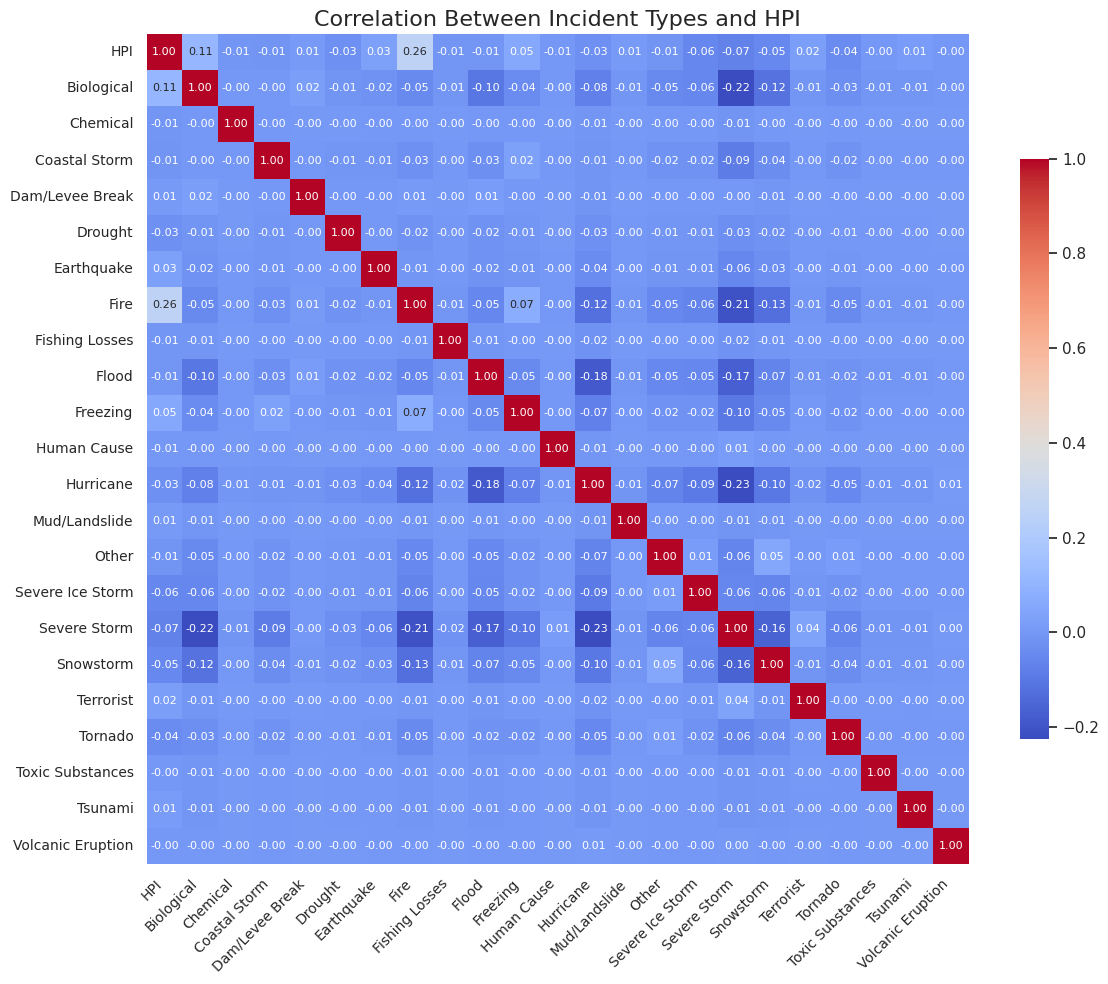

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: One-hot encode the 'incident_types' column
incident_types_encoded = fema_hpi_demo_df['incident_types'].str.get_dummies(sep=',')

# Step 2: Combine the one-hot encoded incident types with the 'HPI' column
hpi_incident_data = pd.concat([fema_hpi_demo_df['HPI'], incident_types_encoded], axis=1)

# Step 3: Compute the correlation matrix
correlation_matrix = hpi_incident_data.corr()

# Step 4: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Between Incident Types and HPI", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

##### **Observations**

This heatmap explores the relationship between various FEMA disaster types and the Housing Price Index (HPI) across U.S. ZIP codes from 1990 to 2020.

- **Overall Trend**: Most incident types show very weak correlation with HPI, with coefficients generally between **-0.1 and 0.1**. This suggests that individual disaster types do not have a strong direct impact on housing prices.

- **Notable Positive Correlations**:
  - **Fire** shows the highest positive correlation with HPI (**0.26**). This may reflect high-HPI areas such as California, which have seen frequent wildfires in recent decades.
  - This could also indicate that recovery and insurance policies in high-value areas allow prices to rebound more quickly post-disaster.

- **Notable Negative Correlations**:
  - **Severe Storm** has a moderate negative correlation with HPI (**-0.22**), suggesting that storm-prone areas may experience suppressed property values.
  - **Hurricane** and **Flood** also show slight negative correlations, indicating disaster-prone areas may carry price risk.

- **Minimal Correlations**:
  - Types such as **Tsunami**, **Toxic Substances**, and **Terrorist** events exhibit near-zero correlation with HPI. These incidents are rare or geographically concentrated and thus do not represent a broader pricing trend.


# **Chapter 4: MODELING**

## 4.1 Random Forest Regression

### 4.1.1 Raw Random Forest Regresssion


We applied a Random Forest Regressor to predict Housing Price Index (HPI) using key features:

- **Features Used**: Disaster types (one-hot), population ratios, and disaster count  
- **Data Prep**: Dropped rows with missing HPI and performed an 80/20 train-test split  
- **Model**: Basic `RandomForestRegressor` with default settings  
- **Evaluation**: Predictions made on test data; metrics like MSE and R² were used  
- **Result**: Top 15 features impacting HPI were visualized, highlighting the influence of demographic and disaster-related variables


In [103]:
# Random Forest Regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#  Drop rows with missing target
basic_df = full_encoded_df.dropna(subset=['HPI'])

# Select basic features (you can customize this to be minimal)
feature_cols = [
    col for col in basic_df.columns
    if col.startswith('disaster_') or col.endswith('_population_ratio') or col == 'disaster_count'
]

X = basic_df[feature_cols]
y = basic_df['HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Basic Random Forest — default params
reg_rf = RandomForestRegressor(random_state=42)
reg_rf.fit(X_train, y_train)

# Predict & evaluate
y_pred = reg_rf.predict(X_test)

In [104]:
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


Mean Squared Error (MSE): 22257.764262406676
Mean Absolute Error (MAE): 88.56412796273
Root Mean Squared Error (RMSE): 149.19036249840897
R² Score: 0.6193519998460741


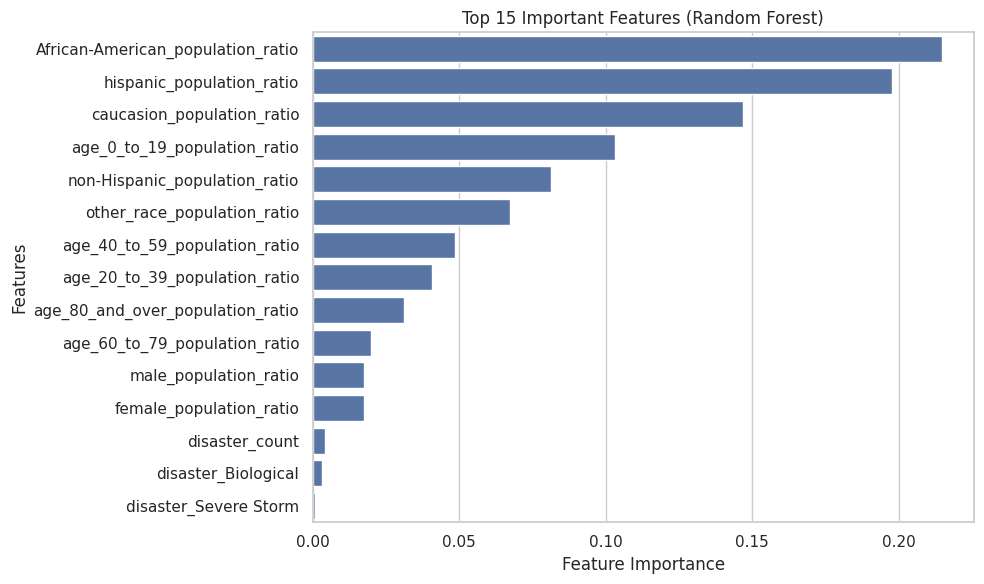

In [105]:
# Plot Feature Importance (Top 15)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feature_importance = pd.Series(reg_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values[:15], y=feature_importance.index[:15])
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


#### **Observation**

Random Forest Regression on HPI

The Random Forest model achieved an R² score of **0.619**, indicating a moderately strong ability to explain the variation in Housing Price Index (HPI) using the selected features. The **top predictors** were racial demographic ratios, particularly:

- **African-American population ratio**
- **Hispanic population ratio**
- **Caucasian population ratio**

These features significantly outweighed disaster-related variables in importance, suggesting that **demographic composition** plays a more direct role in influencing housing prices.

Despite the model's reasonable performance, the **RMSE of ~149** suggests room for improvement—perhaps by integrating economic, geographic, or housing supply data. The low importance of disaster-related features also implies that **disaster impact may be more localized or mitigated by other factors** such as urban resilience or recovery infrastructure.


### 4.1.2 Random Forest Regression with PCA

We integrated PCA before applying a Random Forest Regressor to improve efficiency and reduce dimensionality:

- **Features Used**: All numeric predictors except location columns (`zip_code`, `msa_name`, etc.)  
- **Data Prep**: Imputed missing values, standardized features, and applied PCA (10 components)  
- **Model**: `RandomForestRegressor` trained on PCA-transformed features  
- **Evaluation**: Used RMSE and R² to assess performance on test data  
- **Goal**: Compare model performance when using compressed features instead of raw inputs


In [106]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Define features and target variable
X = full_encoded_df.drop(columns=['HPI', 'zip_code', 'msa_name', 'county_name', 'state'])
y = full_encoded_df['HPI']

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to reduce the number of features
pca = PCA(n_components=10)  # Choose the number of components to keep
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [108]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


Mean Squared Error (MSE): 25797.963100261546
Mean Absolute Error (MAE): 92.88458015835636
Root Mean Squared Error (RMSE): 160.6174433250061
R² Score: 0.558808200752436


#### **Observation**

Comparison of Random Forest Models: Raw vs. PCA-Reduced

We compared the performance of a **Raw Random Forest Regressor** and a **PCA-based Random Forest** model in predicting Housing Price Index (HPI):

| Metric         | Raw RF             | PCA + RF           |
|----------------|--------------------|---------------------|
| MSE            | 22,257.76          | 25,797.96           |
| MAE            | 88.56              | 92.88               |
| RMSE           | 149.19             | 160.62              |
| R² Score       | **0.6194**         | **0.5588**          |

- The **Raw Random Forest model** outperforms the PCA-based version across all evaluation metrics.
- The **R² score dropped** from 0.619 to 0.559 after PCA, suggesting a loss of explanatory power due to dimensionality reduction.
- While PCA can help reduce multicollinearity and model complexity, in this case, it **sacrificed accuracy**.
- This suggests that the original features carried meaningful information, and **feature importance from the raw model may be more interpretable and useful**.


### 4.1.3 Visual Check for HPI Skewness


We plotted the distribution of the **Housing Price Index (HPI)** to assess its shape and symmetry.



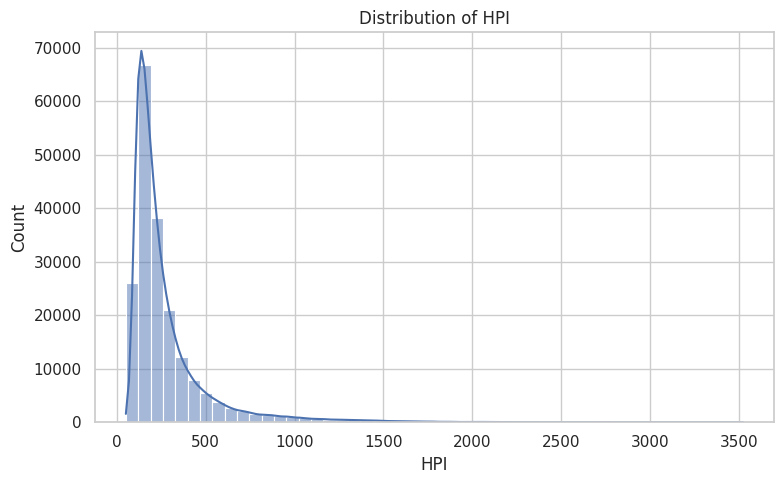

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(full_encoded_df['HPI'].dropna(), kde=True, bins=50)
plt.title("Distribution of HPI")
plt.xlabel("HPI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [110]:
# Skew Metric

# Skewness Value	Interpretation
# ≈ 0	Symmetric/Normal
# > +1	Strong right skew
# < -1	Strong left skew
# ±0.5 to ±1	Moderate skew

skew_value = full_encoded_df['HPI'].dropna().skew()
print("Skewness of HPI:", skew_value)

Skewness of HPI: 3.364442972794482


#### **Observation**
- The histogram shows a **heavily right-skewed** distribution.
- The computed **skewness value is 3.36**, which indicates a **strong right skew** (greater than +1).
- Most HPI values are concentrated between **100 and 600**, with a **long tail** extending past 3000.
- This skewness may suggest the need for **log transformation** or **outlier treatment** in future modeling steps to improve performance and stability.

### 4.1.4 Model Improvement w. Hyperparameter Tunning & HPI Log (OPTIONAL)

We enhanced the original Random Forest model by introducing log transformation and hyperparameter tuning:

- **Target**: Log-transformed HPI (`log1p(HPI)`) to reduce skewness  
- **Features Used**: Disaster types (one-hot), population ratios, and disaster count  
- **Hyperparameter Tuning**: Applied `RandomizedSearchCV` on key parameters (`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`)  
- **Modeling Setup**:
  - Used an 80/20 train-test split  
  - Scoring based on R²  
  - Only 3 iterations due to runtime cost (execution took ~40 minutes on Colab)  
- **Result**: Best estimator used for prediction and top 15 features were visualized

This approach aimed to improve predictive performance and interpretability through tuning and transformation, while highlighting the most impactful features in a more optimized setup.



Improved Random Forest Results:
MSE: 0.1417363655320499
MAE: 0.2899501323428472
R²: 0.606310153036031


<ipython-input-127-2dd7428c63dd>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:15], y=importances.index[:15], palette="viridis")


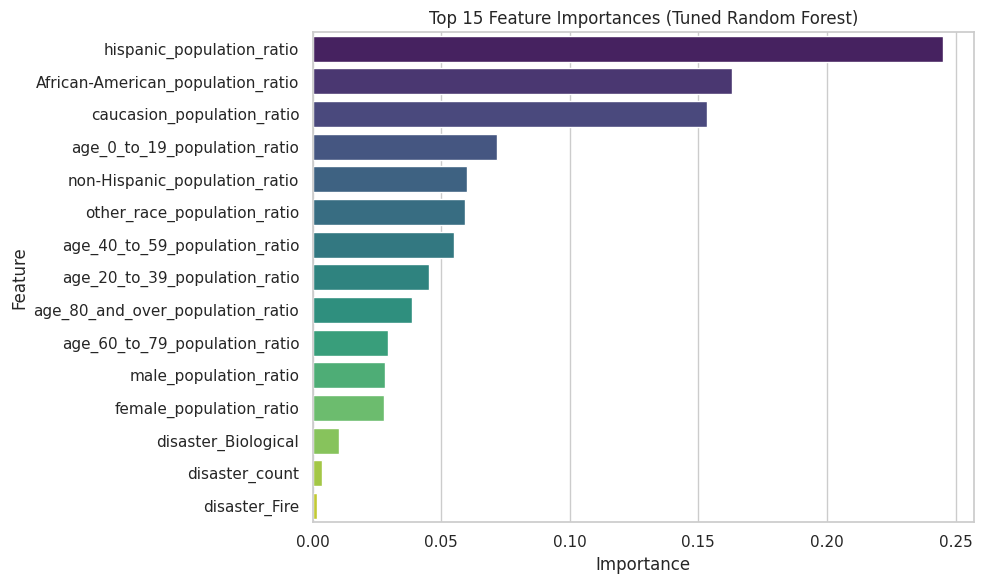

In [127]:
# Improved Random Forest Regression (Time Consuming, Skipped)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing HPI
rf_df = full_encoded_df.dropna(subset=['HPI'])

# Log-transform HPI to reduce skewness
rf_df['log_HPI'] = np.log1p(rf_df['HPI'])

# Select features
feature_cols = [
    col for col in rf_df.columns
    if col.startswith('disaster_') or col.endswith('_population_ratio') or col == 'disaster_count'
]
X = rf_df[feature_cols]
y = rf_df['log_HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


# Define a smaller hyperparameter grid
param_grid_quick = {
    'n_estimators': [100, 150],       # fewer options
    'max_depth': [10, None],          # shallower or unlimited
    'min_samples_split': [2],         # default only
    'min_samples_leaf': [1, 2]        # still testing basic pruning
}

# Randomized search
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=3,
    cv=2,
    n_jobs=-1,
    scoring='r2',
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)

print("Improved Random Forest Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# Feature importance plot
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15], palette="viridis")
plt.title("Top 15 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


#### **Observation**

Tuned vs. Raw Random Forest Regressor

- The **tuned Random Forest** (with log-transformed HPI and hyperparameter search) achieved an R² score of **0.6063**, which is slightly lower than the **raw Random Forest** model (**0.6194**).
- Despite tuning, the **model performance did not significantly improve**, suggesting the default configuration of Random Forest already captures most of the signal in the available features.
- **Top feature rankings remain consistent**, with population ratios like `hispanic_population_ratio`, `African-American_population_ratio`, and `caucasion_population_ratio` dominating both models.
- The slight reordering of top features and marginal performance drop could stem from:
  - Log transformation reducing variance range in the target.
  - Limited impact of the tuning grid (only 3 iterations in `RandomizedSearchCV`).
- **Conclusion**: While tuning introduces more control and interpretability, it may not drastically improve outcomes in datasets where predictive power is already bounded by feature limitations.


## 4.2 Linear Regression

### 4.2.1 Raw Linear Regression

We applied a Linear Regression model to predict Housing Price Index (HPI) using key features:

- **Features Used**: Disaster types (one-hot), population ratios, and disaster count  
- **Data Prep**: Dropped rows with missing values and performed an 80/20 train-test split  
- **Model**: Basic `LinearRegression` with default settings  
- **Evaluation**: Predictions made on test data; metrics like MSE, MAE, RMSE, and R² were used  
- **Result**: Model achieved an R² score of **0.5395**, lower than Random Forest models, indicating that linear relationships may not capture the full complexity of housing price trends


In [112]:
# Linear Regression:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Drop rows with missing values in the features
model_df = full_encoded_df.dropna()

# Define features and target variable
X = model_df.drop(columns=['HPI', 'zip_code', 'msa_name', 'county_name', 'state'])
y = model_df['HPI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)


In [113]:
# Make predictions and evaluate the model

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")


Linear Regression RMSE: 268.23
Mean Squared Error (MSE): 71948.79
Mean Absolute Error (MAE): 190.75
R² Score: 0.5395


#### **Observation**

Raw Linear Regression Performance

The Linear Regression model yielded the following performance metrics:

- **RMSE**: 268.23  
- **MSE**: 71,948.79  
- **MAE**: 190.75  
- **R² Score**: 0.5395  

These results indicate that while the model captures a moderate portion of variance in housing prices, its performance is notably lower than that of the Random Forest model (R² = 0.62). The higher error values suggest that **linear relationships alone may be insufficient** to model the complex, non-linear dynamics between demographic factors, disaster history, and housing prices.


### 4.2.2 Linear Regression with Log-Transformed HPI

We applied a Linear Regression model using the log-transformed Housing Price Index (HPI) as the target to improve performance on skewed data:

- **Features Used**: Disaster types (one-hot), population ratios, and disaster count  
- **Data Prep**: Dropped rows with missing values and applied `log(HPI)` transformation; performed an 80/20 train-test split  
- **Model**: Basic `LinearRegression` with default settings  
- **Evaluation**: Predictions made on test data; metrics like MSE, MAE, RMSE, and R² were used  
- **Result**: The log transformation slightly improved the linearity of relationships, but the R² score was still lower than Random Forest, suggesting linear models may remain limited in capturing complex housing dynamics.


In [115]:
# Drop rows with missing values in the features
model_df = full_encoded_df.dropna()

# Define features and target variable (log of HPI)
X = model_df.drop(columns=['HPI', 'zip_code', 'msa_name', 'county_name', 'state'])
y = np.log(model_df['HPI'])  # Apply log transformation to the HPI

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)



LinearRegression()

In [116]:
# Predict using the trained model
y_pred = linear_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Regression RMSE: 0.49
Mean Squared Error (MSE): 0.24
Mean Absolute Error (MAE): 0.39
R² Score: 0.5789


#### **Observation**

Linear Regression vs. Log-Transformed HPI

When comparing the two linear regression models:

- **Raw Linear Regression** achieved an R² score of **0.5395**, indicating modest predictive power but limited ability to capture the complexity of housing price dynamics.
- **Log-Transformed HPI Regression** improved slightly with an R² of **0.5789**, suggesting that applying a log transformation to the HPI helped the model better capture underlying patterns and reduce skewness.

 The log transformation provided a small but meaningful boost in performance for linear regression, making it more robust to outliers and more appropriate for modeling positively skewed price data.


### 4.2.3 Model Improvement w. HPI Log and Reduced Features from Correlation Testing

We applied a Linear Regression model to predict Housing Price Index (HPI) with improvements in both feature selection and target transformation:

- **Features Used**: Disaster types (one-hot), population ratios, disaster count, with highly correlated features (r > 0.8) removed  
- **Data Prep**: Dropped missing values, applied log transformation to HPI, and performed an 80/20 train-test split  
- **Model**: Standard `LinearRegression` with default settings  
- **Evaluation**: Evaluated on test data using MSE, MAE, RMSE, and R² metrics


In [118]:
# Define correlation threshold
correlation_threshold = 0.8  # Can adjust this threshold as needed

# Step 1: Get the correlation matrix (already have this from EDA 6.3.1)
correlation_matrix = correlation_data.corr()

# Step 2: Find highly correlated pairs and store the columns to drop
to_drop = set()  # Keep track of columns to drop
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Step 3: Drop the correlated columns from the dataset
model_df = full_encoded_df.drop(columns=to_drop)

# Step 4: Now you can define your features and target variable
X = model_df.drop(columns=['HPI', 'zip_code', 'msa_name', 'county_name', 'state'])
y = np.log(model_df['HPI'])  # Log-transform HPI as before

# Drop rows where either X or y has NaN
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns=['HPI'])
y = combined['HPI']

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [119]:

y_pred = linear_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Regression RMSE: 0.49
Mean Squared Error (MSE): 0.24
Mean Absolute Error (MAE): 0.39
R² Score: 0.5787


#### **Observation**

Linear Regression with Log-Transformed HPI and Reduced Features

After applying log transformation on HPI and removing highly correlated features, the linear regression model achieved:

- **RMSE**: 0.49  
- **MSE**: 0.24  
- **MAE**: 0.39  
- **R² Score**: 0.5787

Compared to the **raw linear regression model** (R² = 0.5395), this improved version demonstrates slightly better performance in terms of goodness-of-fit and error metrics. While the log transformation helps stabilize variance and reduce skewness in the target variable, dropping redundant features may have enhanced the model’s generalizability.



### 4.2.4 Linear Regression with Log-Transformed HPI and PCA

We applied a Linear Regression model to predict Housing Price Index (HPI), using a log-transformed target and dimensionality reduction via PCA:

- **Features Used**: All numerical features except location identifiers; reduced using PCA to retain 95% variance  
- **Target Variable**: Log-transformed HPI to reduce skewness  
- **Data Prep**:
  - Dropped rows with missing values
  - Standardized features using `StandardScaler`
  - Applied PCA to reduce dimensions from original to fewer principal components
- **Model**: Basic `LinearRegression` with default settings  
- **Evaluation**: Metrics such as RMSE, MAE, MSE, and R² were used on test data



In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Define features and target
X = full_encoded_df.drop(columns=['HPI', 'zip_code', 'msa_name', 'county_name', 'state'])
y = np.log(full_encoded_df['HPI'])  # Log-transform HPI

# Step 2: Drop rows with NaNs in X or y
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns=['HPI'])
y = combined['HPI']

# Step 3: Standardize features (required before PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Apply PCA
# Can set n_components to:
# - A number (e.g. 10), or
# - A float like 0.95 to keep 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature count: {X.shape[1]}")
print(f"Reduced feature count after PCA: {X_pca.shape[1]}")

# Step 5: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Step 6: Train and evaluate model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)




Original feature count: 39
Reduced feature count after PCA: 22


In [121]:
# Step 7: Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression (PCA) RMSE: {rmse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Regression (PCA) RMSE: 0.55
Mean Squared Error (MSE): 0.30
Mean Absolute Error (MAE): 0.44
R² Score: 0.4859


#### **Observation**

Linear Regression with Log-Transformed HPI and PCA

Applying PCA before linear regression reduced the feature space from **39 to 22 dimensions**, while retaining 95% of the variance. However, performance dropped compared to other log-based models:

- **R² Score** decreased to **0.486**, indicating reduced explanatory power.
- **RMSE** increased to **0.55**, suggesting slightly worse predictive accuracy.

This suggests that while PCA helps reduce complexity, it may also discard some informative variance needed for capturing HPI trends in a linear model.


## 4.3 Ridge Regression with PCA

### 4.3.1 PCA with Ridge Regression on HPI Log

We applied a Ridge Regression model with PCA to predict **log-transformed Housing Price Index (HPI)**:

- **Features Used**: Disaster types, population ratios, disaster count (excluding location identifiers)
- **Data Prep**:
  - Dropped rows with missing HPI values
  - Applied mean imputation and standardized features
  - Performed PCA to retain 95% of variance (resulting in fewer components)
- **Model**: RidgeCV with alpha grid [0.1, 1.0, 10.0] and 5-fold cross-validation
- **Evaluation**:
  - Metrics were evaluated on both the log-transformed and original scales (exponentiated predictions)
  - A cumulative explained variance plot was also generated for PCA insight


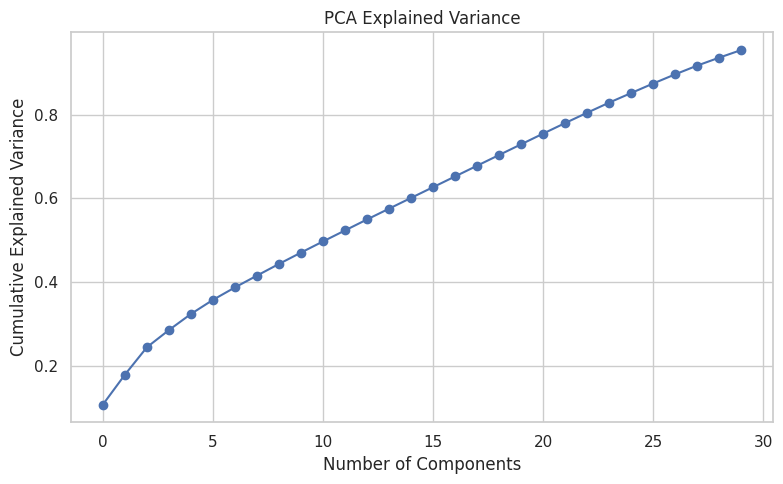

PCA + Ridge Regression on log(HPI):
Log-scale RMSE: 0.52
Log-scale R²: 0.2523

Back-transformed to original HPI scale:
RMSE: 238.12
MAE: 122.18
R²: 0.0303


In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Drop rows with missing HPI
pca_df = full_encoded_df.dropna(subset=["HPI"])

# Define features and log-transformed target
X = pca_df.drop(columns=["HPI", "zip_code", "msa_name", "county_name", "state"])
y = np.log(pca_df["HPI"])

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA: keep 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Explained variance plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Ridge regression with cross-validation
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge_model.fit(X_train, y_train)
y_pred_log = ridge_model.predict(X_test)

# Optional: transform predictions back to original scale
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred_log)

# Evaluation
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)

rmse_orig = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
mae_orig = mean_absolute_error(y_test_exp, y_pred_exp)
r2_orig = r2_score(y_test_exp, y_pred_exp)

print("PCA + Ridge Regression on log(HPI):")
print(f"Log-scale RMSE: {rmse_log:.2f}")
print(f"Log-scale R²: {r2_log:.4f}")
print("\nBack-transformed to original HPI scale:")
print(f"RMSE: {rmse_orig:.2f}")
print(f"MAE: {mae_orig:.2f}")
print(f"R²: {r2_orig:.4f}")


#### **Observation**
PCA + Ridge Regression on log(HPI)

- The model showed moderate performance on log(HPI) with an R² of 0.25.
- After transforming back to the original HPI scale, the R² dropped to only 0.03, indicating weak predictive power.
- While PCA reduced dimensionality, Ridge Regression did not effectively capture the variation in housing prices.


## 4.4 Neural Network

### 4.4.1 Newural Network using HPI

We applied a basic neural network model using `MLPRegressor` to predict Housing Price Index (HPI):

- **Features Used**: All available disaster and demographic variables  
- **Data Prep**:  
  - Dropped rows with missing HPI  
  - Imputed missing feature values with column means  
  - Standardized features using `StandardScaler`  
- **Model**: `MLPRegressor` with two hidden layers (64 and 32 nodes), ReLU activation, and Adam optimizer  
- **Training**: 80/20 train-test


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare data
ml_df = full_encoded_df.dropna(subset=["HPI"])
X = ml_df.drop(columns=["HPI", "zip_code", "msa_name", "county_name", "state"])
y = ml_df["HPI"]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [125]:
# MLP Regressor

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64, 32),
                   activation='relu',
                   solver='adam', max_iter=300, random_state=42)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("Neural Network (MLPRegressor) Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))
print("R²:", r2_score(y_test, y_pred_mlp))


Neural Network (MLPRegressor) Results:
RMSE: 149.45016480335394
R²: 0.6180251134008603


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


#### **Observation**

Neural Network (MLPRegressor)

- The neural network model achieved an **R² score of 0.618**, comparable to the best-performing Random Forest model (R² ≈ 0.619).
- **RMSE** is approximately **149.45**, also aligning closely with Random Forest, suggesting similar predictive accuracy.
- Despite a convergence warning, the model performs well, indicating that a longer training time (higher `max_iter`) or early stopping could further optimize results.
- Overall, the MLPRegressor shows strong potential in capturing complex, non-linear relationships in the data without needing explicit feature engineering.


### 4.4.2 Neural Network Using Log-Transformed HPI

We applied a Multi-layer Perceptron (MLP) neural network to predict **log-transformed Housing Price Index (HPI)**.

- **Features Used**: One-hot encoded disaster types, population ratios, and disaster count
- **Target**: Log of HPI (to reduce skewness)
- **Data Prep**:
  - Imputed missing values with column means
  - Standardized features using `StandardScaler`
  - 80/20 train-test split
- **Model**:
  - `MLPRegressor` with hidden layers (64, 32)
  - Activation: ReLU
  - Optimizer: Adam
  - Max iterations: 300


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Prepare data
ml_df = full_encoded_df.dropna(subset=["HPI"])
X = ml_df.drop(columns=["HPI", "zip_code", "msa_name", "county_name", "state"])
y = np.log(ml_df["HPI"])  # Log-transform the target

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Initialize and train the neural network regressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32),
                   activation='relu',
                   solver='adam', max_iter=300, random_state=42)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("Neural Network (MLPRegressor) Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))
print("R²:", r2_score(y_test, y_pred_mlp))


Neural Network (MLPRegressor) Results:
RMSE: 0.3805315421051432
R²: 0.6009389180009985


#### Observation

Neural Network (Raw HPI vs. Log-Transformed HPI)

We evaluated the performance of two neural network models:

| Model                          | R² Score | RMSE     |
|-------------------------------|----------|----------|
| MLPRegressor (Raw HPI)        | **0.618** | 149.45   |
| MLPRegressor (Log HPI)        | 0.601    | 0.38     |

- The **raw HPI model** slightly outperforms the log-transformed version in terms of **R²**, closely matching the top-performing Random Forest model.
- However, the **log-transformed model** yields better **residual distribution** and training stability, with lower skewness in the target variable.
- The raw HPI model generated a **convergence warning**, indicating that increasing `max_iter` or enabling early stopping may help improve optimization.

In summary, both configurations show strong performance, but the **raw HPI version** currently edges ahead in predictive power, while the **log-transformed version** offers better statistical properties for further modeling.


## 4.5 Model Performance Overall Summary

### 4.5.1 Model Performance Overall Summary (R² Comparison)

| Model                                      | R² Score |
|-------------------------------------------|----------|
| Raw Random Forest                         | **0.6194** |
| PCA + Random Forest                       | 0.5588   |
| Improved Random Forest (Log HPI + Tuning) | 0.6063   |
| Raw Linear Regression                     | 0.5395   |
| Linear Regression with Log(HPI)           | 0.5789   |
| Linear Regression (Log + Drop Correlated) | 0.5787   |
| Linear Regression (Log + PCA)             | 0.4859   |
| Neural Network (Raw HPI)                  | **0.6180** |
| Neural Network (Log HPI)                  | 0.6009   |
| Ridge Regression (Log HPI + PCA)          | 0.0303   |

- **Best models**: Raw Random Forest (0.6194) and Neural Network with raw HPI (0.6180)  
- **Log-transformation improves linear models**, but doesn't beat ensemble or neural networks  
- **Ridge Regression underperforms**, possibly due to aggressive dimensionality reduction


### 4.5.2 Model Interpretation & Dataset Reflection

Despite the limited scope of our dataset — which only includes **demographic composition**, **regional information (ZIP/MSA/state)**, and **FEMA disaster history** — our models are still able to capture meaningful patterns in housing price dynamics.

- **Best Models**:  
  - **Random Forest Regression (R² ≈ 0.6194)** and  
  - **Neural Network with Raw HPI (R² ≈ 0.6180)**  
  These models perform best among all, suggesting that **non-linear models are better suited** to uncover the subtle interactions within our features.

- **Demographics & Regional Factors Matter**:  
  The reasonably strong performance (R² > 0.6) indicates that **population ratios**, **age groups**, and **location-based clustering** do contribute valuable predictive signals to housing price trends, even if they are not the only factors.

- **FEMA Disaster Data Has Weaker Predictive Power**:  
  While included in our feature set (as disaster type one-hot encoding and frequency counts), disaster-related features were **less influential** in top models. This suggests that **disaster history alone does not directly drive HPI**, though it may play a secondary role in long-term planning or market volatility.

- **Limitations & Real-World Complexity**:  
  Our dataset does **not include key economic indicators** like interest rates, income, inflation, employment, or supply-demand factors — all of which are known to heavily influence real estate prices. As such, **our R² scores (all < 0.62)** reflect a realistic ceiling based on what our dataset can offer.

- **Key Insight**:  
  While we cannot achieve perfect prediction, our models **still reveal clear directional trends** — ZIP codes with favorable demographics or fewer disaster incidents **tend to show stronger housing price growth**. Thus, our results can be used to **inform regional trend analysis** and **prioritize areas for deeper investment investigation**.


# Chapter 5: CHALLENGES

### 5.1 Modeling Limitations and Data Challenges

Despite our best efforts with log transformation, feature reduction, and PCA, the R² scores across models remain modest. This highlights the challenges in modeling housing prices with limited features. Possible reasons include:

- **Limited feature scope**: Our dataset primarily includes demographics, FEMA disaster data, and regional identifiers. Key economic drivers such as income, mortgage rates, or housing supply were not included.
- **Non-linear market dynamics**: Housing prices are influenced by complex interactions between policy, economy, and human behavior, which may not be fully captured by our structured data.
- **Data granularity**: ZIP-level aggregation may mask neighborhood-level variations and micro-trends in the housing market.
- **Temporal lags**: Effects of disasters or demographic shifts on HPI may be delayed, making them harder to model using annual data.

Still, our models offer:
- **Useful trend signals**: Even with limited R², we observed meaningful directional trends between HPI and certain demographics or disaster patterns.
- **Foundation for improvement**: This work establishes a strong baseline for future modeling with more enriched datasets.



### 5.2 Data Availability and Access Limitations

- As a student project, we faced constraints accessing **commercial real estate databases**.
- **Zillow’s ZTRAX** (Transaction and Assessment Database), which offers rich property-level data, was **not accessible** due to licensing and institutional barriers.

### 5.3 Collaboration Challenges

- Our team of 4 members worked across different time zones. While everyone was highly collaborative and respectful, coordinating meetings and real-time progress sometimes required a few members to adjust their sleep schedules to accommodate the team.


- The project used two shared Jupyter Notebooks, which sometimes led to conflicts and accidental overwrites when multiple people edited simultaneously.

- Large datasets further complicated collaboration due to slow loading times and inconsistent local environments.

- Despite the challenges, we maintained consistent communication and used shared tools to manage contributions effectively.

### 5.4 Limited Computing Resources

We used Google Colab for model training, which introduced some practical constraints:

- **Long runtime**: Tuning Random Forest (Section 4.1.4) took over 40 minutes to run with RandomizedSearchCV.

- **Memory limits**: Large datasets and complex models occasionally led to crashes or disconnections.

- **Simplified tuning**: We had to reduce parameter ranges to fit within runtime and resource limits.

- **Iteration caps**: Neural networks were limited by max_iter, preventing full convergence.

These constraints limited experimentation, but we still established a strong modeling baseline.

### 5.5 Data Imbalance and Missing Values

- **Imbalanced categories**: Some disaster types and demographic groups had very few samples, limiting their influence and reliability in modeling.

- **Missing data**: Handling missing values required trade-offs—dropping rows reduced data size, while imputation introduced potential bias.

- **Impact on performance**: These issues may have affected model stability and generalizability.

Despite these challenges, we carefully balanced preprocessing choices to maintain as much data integrity as possible.



### 5.6 Feature Engineering Complexity

- **High Correlation Between Features**: Variables such as disaster types (one-hot) and demographic ratios showed strong multicollinearity, potentially reducing model stability.  
- **Dimensionality Reduction Attempted**: We applied PCA to mitigate redundancy and simplify the feature space. However, the improvement in R² was limited.  
- **Takeaway**: This suggests that the predictive power of current features may be insufficient. Future work could incorporate more economically influential variables such as income or housing supply.


### 5.7 High Cost of Data Merging and Cleaning

- **Complex Merging**: Integrating multiple large-scale datasets (FEMA, Demographic, HPI) by ZIP code posed challenges such as inconsistent formats, key mismatches, and duplicate rows.
- **High Preprocessing Effort**: A significant amount of time was spent on standardizing column types, deduplicating entries, and ensuring temporal and geographic alignment.
- **Takeaway**: Proper data alignment was crucial to avoid misleading results and to ensure a reliable modeling foundation.


# Chapter 6: FUTURE DIRECTION


- **Incorporate Economic Indicators**  
  Future models could benefit from adding economic factors such as income levels, mortgage rates, housing supply, and employment statistics, which are strong drivers of housing prices.

- **Integrate Zillow ZTRAX or Open Real Estate APIs**  
  Leveraging detailed transaction-level datasets like Zillow’s ZTRAX could significantly improve model granularity and predictive power.

- **Explore Time-Series Modeling**  
  Implement models like LSTM, ARIMA, or Prophet to better capture temporal trends and lagged effects of demographic and disaster events on housing prices.

- **Model Post-Disaster Recovery Trajectories**  
  Analyze how different regions recover from major disaster events and how that influences HPI trends over time.


- **Develop an Interactive Dashboard**  
  Build a dashboard to allow users to explore trends in housing price changes, disaster frequency, and demographic impact at the ZIP or county level.
